In [8]:
import numpy as np
import matplotlib as plt
import matplotlib.pyplot as pyplt

In [ ]:
# P1 has been merged at the end 

## Q2

# FLDA for Multi-Class Classificiation on P3

Train X (60000, 10)
Training Y (60000, 1)
No. of Unique Classes  5
are there complex eigen values of Sb^-1.Sw:  False
Accuracy is 65.97333333333333


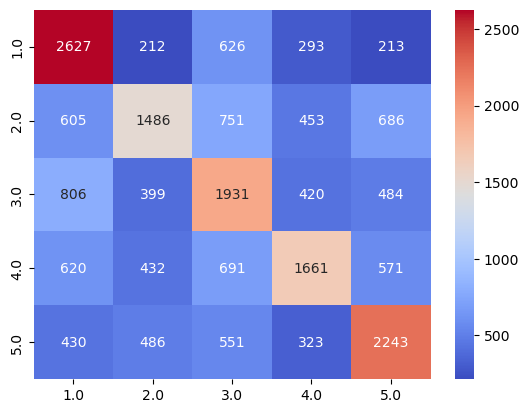

F1 Scores
[0.5799757147588034, 0.42481417953116063, 0.44959254947613503, 0.4662456140350877, 0.545078979343864]


In [ ]:
import numpy as np
import math


def load_data(filename):
    """
    Load data from a CSV file and split it into feature vectors and labels.
    
    Args:
    filename: string containing the name of the CSV file to load.
    
    Returns:
    x: ndarray of shape (m, n) containing the feature vectors.
    y: ndarray of shape (m, 1) containing the labels.
    """
    data_np = np.loadtxt(filename, delimiter=",")
    m, n = np.shape(data_np)
    x = np.ones((m, n-1))
    y = np.zeros((m, 1))
    for k in range(m):
        x[k,:n-1] = data_np[k,:n-1]
        y[k] = data_np[k,n-1]
    return x, y

# load data
x_train, y_train = load_data("p3_train.csv")
print("Train X", np.shape(x_train))
print("Training Y",np.shape(y_train))
x_test, y_test = load_data("p3_test.csv")




#separating data based on classes

def class_separator(x, y):

# get the unique classes
    classes = np.unique(y)

# create a dictionary to store the arrays
    data_by_class = {}

# loop over each class
    for c in classes:
# get the indices of data points belonging to this class
        indices = np.where(y == c)[0]
    
# extract the data points and store them in a new array
        data = x[indices, :]
    
# store the array in the dictionary
        data_by_class[c] = data
    return data_by_class

# computing class_means
def FLDA(x, y):
    data = class_separator(x, y)
    num_classes = len(data.keys())
    c_means = np.zeros((num_classes, x.shape[1]))
    print("No. of Unique Classes ", num_classes)
    for i in range(num_classes):
        c_means[i,:] = np.mean(data[i+1], axis=0)
    

# computing within class scatter matrix
    Sw = np.zeros((x.shape[1], x.shape[1]))
    for i in range(num_classes):
        p = data[i+1]
        no_in_class = p.shape[0] 
        for j in range(no_in_class):
            diff = p[j,:] - c_means[i,:]
            Sw += np.outer(diff, diff)
    

# computing between class scatter matrix
    
    Sb = np.zeros((x.shape[1], x.shape[1]))
    for i in range(num_classes):
        p = data[i+1]
        overall_sum = np.sum(p, axis=0)
    overall_mean = (1/(x.shape[0]))*overall_sum
    
    for i in range(num_classes):
        p = data[i+1]
        n = p.shape[0]
        mean_diff = c_means[i,:] - overall_mean
        Sb += n*np.outer(mean_diff, mean_diff)
    
    
# computing eigen vectors and eigen values of Sb^-1.Sw  
    Sb_inv = np.linalg.inv(Sb)
    Sb_inv_Sw = Sb_inv @ Sw
    eigvals, eigvecs = np.linalg.eig(Sb_inv_Sw)
    
# Sort the eigenvectors by eigenvalue in decreasing order
    sort_indices = np.argsort(eigvals)[::-1]
    eigvals = eigvals[sort_indices]
    eigvecs = eigvecs[:, sort_indices]

# Select the top (num_classes - 1) eigenvectors
    w = eigvecs[:, :num_classes - 1]
    b = w.T @ overall_mean.reshape(-1, 1)
    
    return w, b, c_means

def classifier(x_transformed, c_mean_transformed):
    dist = np.zeros((c_mean_transformed.shape[0]))
    for i in range(c_mean_transformed.shape[0]):
        dist[i] = np.linalg.norm(x_transformed - c_mean_transformed[i])
    y = np.argmin(dist)
    return y



def gaussian(x_test_proj, class_means, w):
    data = class_separator(x_train, y_train)
    num_classes = len(data.keys())
    gauss = np.zeros((num_classes))
    for i in range(num_classes):
        p = data[i+1]
        p_proj = p @ w
        sigma = np.cov(p_proj, rowvar = False)
        dim = sigma.shape[0]
        sig_inv = np.linalg.inv(sigma)
        det = np.linalg.det(sig_inv)
        kernel = math.exp(-0.5*(x_test_proj-class_means[i]) @ sig_inv @ (x_test_proj-class_means[i]).T)
        gauss[i] = (det**0.5)*kernel*(1/2*3.14)**(dim/2)
    y_est = np.argmax(gauss)+1
    return y_est
        
  
 #Data transforming  by projecting onto W direction
def data_transform(x_train, y_train):
    w, b, c_means = FLDA(x_train, y_train)
    w = np.real(w)
    print("are there complex eigen values of Sb^-1.Sw: ", np.iscomplex(w).any())

    x_proj = x_test @ w 
    c_means_proj = c_means @ w
    return x_proj, c_means_proj, w

def estimation(x_test, x_proj, c_means_proj, w):
    y_est = np.zeros((x_test.shape[0],1))
    for i in range(x_test.shape[0]):
        y_est[i] = gaussian(x_proj[i,:], c_means_proj, w)
    return y_est

def get_confusion_matrix(y_actual, y_pred):
    import matplotlib.pyplot as plt
    import seaborn as sns

    num_classes = len(np.unique(y_actual))
    confusion_matrix = np.zeros((num_classes,num_classes))
    n = y_actual.shape[0]
    labels = np.unique(y_actual)
    labels.sort()
    for i in range(n):
        confusion_matrix[int(y_actual[i]-1)][int(y_pred[i]-1)]+=1
    lamda = 1000*np.identity(len(np.unique(y_actual)))
    confusion_matrix += lamda
    sns.heatmap(confusion_matrix, annot=True,fmt = "g" ,cmap='coolwarm',xticklabels=labels, yticklabels=labels)
    plt.show()
    return confusion_matrix

def metrics(y_est, x_test, y_test):
    count = 0
    for i in range(x_test.shape[0]):
        if y_est[i] == y_test[i]:
            count +=2
    accuracy = count/x_test.shape[0]
    print("Accuracy is",accuracy*100)
    
    cm = get_confusion_matrix(y_test, y_est) 
# Compute F1 score
    f1_list = []
    for i in range(len(np.unique(y_test))):
        tp = cm[i, i]
        fp = sum(cm[:, i]) - tp
        fn = sum(cm[i, :]) - tp
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        f1 = 2 * precision * recall / (precision + recall) if tp > 0 else 0
        f1_list.append(f1)
    print("F1 Scores")
    print(f1_list)
    return 

x_proj, c_means_proj, w = data_transform(x_train, y_train)
y_pred = estimation(x_test, x_proj, c_means_proj, w)
metrics(y_pred, x_test, y_test)                       

# FLDA for P4

In [ ]:
#@title Default title text
import numpy as np

def load_data(filename):
    """
    Load data from a CSV file and split it into feature vectors and labels.
    
    Args:
    filename: string containing the name of the CSV file to load.
    
    Returns:
    x: ndarray of shape (m, n) containing the feature vectors.
    y: ndarray of shape (m, 1) containing the labels.
    """
    data_np = np.loadtxt(filename, delimiter=",")
    return data_np

whole_data = load_data("p4.csv")

# assuming your numpy array is called 'data' with input and output columns
X = whole_data[:, :-1] # input features
y = whole_data[:, -1] # output

# set random seed for reproducibility
np.random.seed(42)

# shuffle the data
n_samples = data.shape[0]
shuffle_idx = np.random.permutation(n_samples)
X_shuffled = X[shuffle_idx]
y_shuffled = y[shuffle_idx]

# split into training and test data, with 80% for training and 20% for test
n_train_samples = int(n_samples * 0.8)
X_train = X_shuffled[:n_train_samples]
y_train = y_shuffled[:n_train_samples]
X_test = X_shuffled[n_train_samples:]
y_test = y_shuffled[n_train_samples:]

# check the shape of the train and test data
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")



x_proj, c_means_proj, w = data_transform(x_train, y_train)
y_pred = estimation(x_test, x_proj, c_means_proj, w)
y_pred = (np.rint(y_pred)).astype(int)
metrics(y_pred, x_test, y_test)   




In [ ]:
metrics(y_pred,y_test)


Classification Accuracy  on Test Data is:  88.49444444444444 

Confusion Matrix is: 
 [[1742.    3.   13.   11.    9.    3.    0.    0.    6.   13.]
 [   3. 1712.   14.    2.   42.    0.    1.    1.    1.   24.]
 [   2.    0. 1478.  154.   50.    0.   53.    0.    0.   63.]
 [   1.    0.    7. 1730.   52.    0.    5.    0.    1.    4.]
 [   9.   11.   11.   67. 1684.    1.    3.   13.    1.    0.]
 [   3.    0.   67.   25.    3. 1547.  153.    0.    2.    0.]
 [  10.    0.  181.  137.   12.  302. 1130.    0.    3.   25.]
 [   6.    2.    3.   15.    6.    0.    0. 1669.   48.   51.]
 [   1.    0.    4.   76.    6.    9.   13.   40. 1642.    9.]
 [ 148.    1.   27.   12.    7.    2.    3.    3.    2. 1595.]] 

f1 Score of Class  1  is:  0.9353020134228188
f1 Score of Class  2  is:  0.9702465287616889
f1 Score of Class  3  is:  0.8199722607489597
f1 Score of Class  4  is:  0.8587738893025565
f1 Score of Class  5  is:  0.917461182239172
f1 Score of Class  6  is:  0.8444323144104803
f1 Sco

# FLDA P5

In [ ]:
#@title Default title text
import numpy as np

def load_data(filename):
    """
    Load data from a CSV file and split it into feature vectors and labels.
    
    Args:
    filename: string containing the name of the CSV file to load.
    
    Returns:
    x: ndarray of shape (m, n) containing the feature vectors.
    y: ndarray of shape (m, 1) containing the labels.
    """
    data_np = np.loadtxt(filename, delimiter=",")
    return data_np

whole_data = load_data("PCA_MNIST.csv")

# assuming your numpy array is called 'data' with input and output columns
X = whole_data[:, :-1] # input features
y = whole_data[:, -1] # output

# set random seed for reproducibility
np.random.seed(42)

# shuffle the data
n_samples = data.shape[0]
shuffle_idx = np.random.permutation(n_samples)
X_shuffled = X[shuffle_idx]
y_shuffled = y[shuffle_idx]

# split into training and test data, with 80% for training and 20% for test
n_train_samples = int(n_samples * 0.8)
X_train = X_shuffled[:n_train_samples]
y_train = y_shuffled[:n_train_samples]
X_test = X_shuffled[n_train_samples:]
y_test = y_shuffled[n_train_samples:]

# check the shape of the train and test data
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")



x_proj, c_means_proj, w = data_transform(x_train, y_train)
y_pred = estimation(x_test, x_proj, c_means_proj, w)
y_pred = (np.rint(y_pred)).astype(int)
  




In [ ]:
metrics(y_pred,y_test)

Classification Accuracy  on Test Data is:  81.74444444444444 

Confusion Matrix is: 
 [[1642.    1.   62.    7.    4.    0.    1.   20.   21.   42.]
 [  21. 1557.   20.    1.  136.    0.   11.    2.    0.   52.]
 [   2.    2. 1473.  147.   28.    3.   75.    0.    2.   68.]
 [   0.    0.   22. 1703.   58.    3.    4.    4.    1.    5.]
 [   0.    7.   92.  107. 1580.    2.    5.    7.    0.    0.]
 [   0.    3.   48.   51.    4. 1169.  521.    0.    1.    3.]
 [  10.    0.  185.  203.    6.  311. 1053.    3.    2.   27.]
 [  10.    3.   10.   29.   19.    2.    1. 1586.   86.   54.]
 [   6.    0.   30.  114.    4.    6.   33.   61. 1512.   34.]
 [ 183.    0.   90.   21.   10.    0.    2.   36.   19. 1439.]] 

f1 Score of Class  1  is:  0.8938486663037561
f1 Score of Class  2  is:  0.9232137563000297
f1 Score of Class  3  is:  0.7687891440501045
f1 Score of Class  4  is:  0.8142481472627301
f1 Score of Class  5  is:  0.8659906823787339
f1 Score of Class  6  is:  0.7093446601941747
f1 Sc

# INFERENCES

In [ ]:
• FLDA is a linear classification technique that works best when there is a clear linear boundary between the classes, as 
it projects the data onto a lower-dimensional subspace to maximize class separation.
• However, if the classes are not linearly separable or if the class distribution is unbalanced, FLDA may not perform as well
as other algorithms like SVM, which can handle non-linear and unbalanced datasets better.
• FLDA's performance is dependent on the linearity and separability of the data, and it may not be the best choice for complex
or non-linear datasets.
• FLDA requires normally distributed data for each labeled class to work optimally, and its accuracy may decrease if the data 
is not normally distributed.
• In the sensor dataset, the low accuracy obtained with FLDA and the Bayes classifier with Gaussian class conditionals in
Assignment 1 suggest that the underlying class conditionals may not be normally distributed.
• If the classes overlap extensively, it becomes challenging for most classifiers, including FLDA, to produce accurate results
since it is difficult to separate the classes with a linear decision boundary.
• Overall, the low accuracy obtained with FLDA in the sensor dataset may indicate that the underlying class conditionals are
not normally distributed or that the classes overlap significantly.
• Additionally, if the classes are overlapping to a great extent, it becomes difficult for most classifiers, including 
FLDA, to produce good results. This is because it becomes challenging to separate the classes with a linear decision boundary.
• In summary, the low accuracy obtained with FLDA in the sensor dataset may indicate that the underlying class conditionals
might not be normally distributed or that the classes are overlapping to a great extent.

It might be inferred conviniently that the data in P3 is highly overlapping that is the between class scatter is low or might be that 
the within class scatter is very high that one class is having multiple points that can be present in the ambit of other class too.

The results from P4 and P5 on the other hand are quite oppposite to what P3 is. The high disparity in confusion matrices computed 
infer that the classes are far apart or there is little to no overlap between the classes which might be a characteristic because
underlying low within scatter and/or high between scatter which might be the result behind such high accuracies of classification.

#**Q3** 

# Overfit Model w/o regularization-model1



Training parameters

+--------------------+---------------+--------------+-----------+----------+
|   Model Complexity |      Variance |         Bias |       MSE |      MAE |
+====================+===============+==============+===========+==========+
|                  0 |   7.88861e-31 | -7.50333e-16 | 668.235   | 21.5864  |
+--------------------+---------------+--------------+-----------+----------+
|                  1 | 663.175       | -7.50333e-16 |   5.05968 |  1.79175 |
+--------------------+---------------+--------------+-----------+----------+
|                  2 | 663.177       | -7.50333e-16 |   5.05734 |  1.79129 |
+--------------------+---------------+--------------+-----------+----------+
|                  3 | 663.18        | -1.50726e-13 |   5.05514 |  1.79111 |
+--------------------+---------------+--------------+-----------+----------+
|                  4 | 663.183       | -8.0945e-15  |   5.05206 |  1.79031 |
+--------------------+---------------+--------------+-

<function matplotlib.pyplot.show(close=None, block=None)>

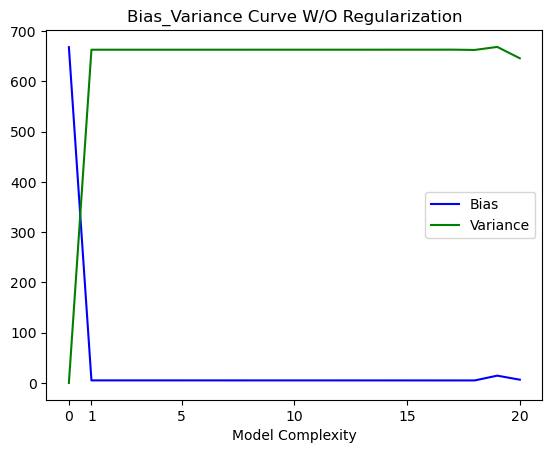

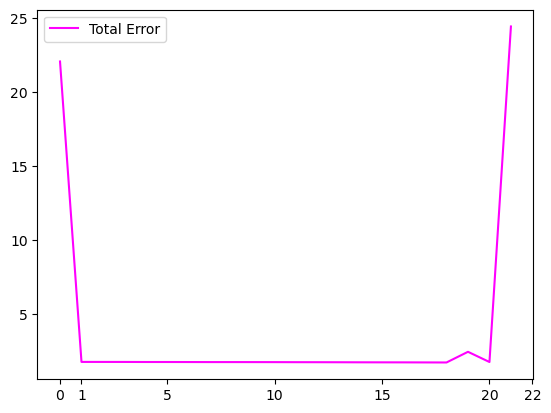

In [ ]:
!pip install tabulate

import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
from tabulate import tabulate

def load_data(filename):
    """
    Load data from a CSV file and split it into feature vectors and labels.
    
    Args:
    filename: string containing the name of the CSV file to load.
    
    Returns:
    x: ndarray of shape (m, n) containing the feature vectors.
    y: ndarray of shape (m, 1) containing the labels.
    """
    data_np = np.loadtxt(filename, delimiter=",")
    m, n = np.shape(data_np)
    x = np.ones((m, n-1))
    y = np.zeros((m, 1))
    for k in range(m):
        x[k,:n-1] = data_np[k,:n-1]
        y[k] = data_np[k,n-1]
    return x, y

def generate_polynomial_features(X, n):
    """
    Generates polynomial features of degree n for a 2-dimensional input array X.
    
    Args:
    X: ndarray of shape (m, 2) containing the input data.
    n: integer degree of the polynomial features to generate.
    
    Returns:
    X_poly: ndarray of shape (m, (n+1)*(n+2)//2) containing the polynomial features.
    """
    m = X.shape[0]
    X_poly = np.ones((m, (n+1)*(n+2)//2))
    idx = 0
    for i in range(n+1):
        for j in range(i+1):
            X_poly[:, idx] = (X[:, 0]**(i-j)) * (X[:, 1]**j)
            idx += 1
    return X_poly

def fit_model(x, y, degree):
    """
    Fits an overparameterized polynomial model of degree n to the input data.
    
    Args:
    x: ndarray of shape (m, 2) containing the input feature vectors.
    y: ndarray of shape (m, 1) containing the input labels.
    n: integer degree of the polynomial model to fit.
    
    Returns:
    coefficients: ndarray of shape ((n+1)*(n+2)//2, 1) containing the fitted model coefficients.
    """
    x_poly = generate_polynomial_features(x, degree)
    coefficients = inv(x_poly.T @ x_poly) @ x_poly.T @ y
    return coefficients

def evaluate_model(x, y, coefficients, degree):
    """
    Evaluates the performance of the model on the input data using mean absolute error and mean squared error.
    
    Args:
    x: ndarray of shape (m, 2) containing the input feature vectors.
    y: ndarray of shape (m, 1) containing the input labels.
    coefficients: ndarray of shape ((n+1)*(n+2)//2, 1) containing the fitted model coefficients.
    
    Returns:
    mae: float containing the mean absolute error of the model predictions.
    mse: float containing the mean squared error of the model predictions.
    """
    y_est = np.dot(generate_polynomial_features(x, degree), coefficients)
    
    bias = np.mean(np.full(np.shape(y_est), np.mean(y_est)) - y)
    mae = np.mean(np.abs(y_est - y))
    mse = np.mean((y_est - y) ** 2)
    variance = np.mean((np.full(np.shape(y_est), np.mean(y_est))-y_est)**2)
    return variance, bias, mse, mae

# Load training and testing data
x_train, y_train = load_data("p1_train.csv")
x_test, y_test = load_data("p1_test.csv")


k =  np.linspace(0,20,21)
# Fit the overparameterized model to the training data
result = np.zeros((21,5))

print("\nTraining parameters\n")

for i in range(21):
    coefficients_train = fit_model(x_train, y_train, i)
    variance, bias, mae, mse = evaluate_model(x_train, y_train, coefficients_train, i)  
    result[i,0] = i
    result[i,1] = variance
    result[i,2] = bias
    result[i,3] = mae
    result[i,4] = mse

param = list(result)
param = [["Model Complexity","Variance","Bias","MSE","MAE"]] + param
print(tabulate(param, headers ='firstrow', tablefmt = 'grid'))


#Plotting Bias_Variance Curves  

plt.figure()
plt.plot(k, result[:,3], color ='blue', label='Bias')
plt.plot(k,result[:,1], color ='green', label='Variance')
plt.xticks([0, 1, 5, 10, 15, 20])
plt.xlabel("Model Complexity")
plt.title("Bias_Variance Curve W/O Regularization")
plt.legend()
plt.show



# Fit the overparameterized model to the testing data

result_test = np.zeros((22,3))
print("\nTesting parameters\n")

for l in range(22):
    coefficients_test = fit_model(x_test, y_test, l)
    variance, bias, mae, mse = evaluate_model(x_test, y_test, coefficients_test, l)  
    result_test[l,0] = l
    result_test[l,1] = mae
    result_test[l,2] = mse

param_test = list(result_test)
param_test = [["Model Complexity","MSE","MAE"]] + param_test
print(tabulate(param_test, headers ='firstrow', tablefmt = 'grid'))

p = np.linspace(0,21,22)
plt.figure()
plt.xticks([0, 1, 5, 10, 15, 20, 22])
plt.plot(p, result_test[:,2], color='magenta', label='Total Error')
plt.legend()
plt.show



# L2 RIDGE REGULARIZED REGRESSION-model1


Training parameters

╒════════════════════╤═══════════════╤══════════════╤═══════════╤══════════╤═══════════════╕
│   Model Complexity │      Variance │         Bias │       MSE │      MAE │   Total Error │
╞════════════════════╪═══════════════╪══════════════╪═══════════╪══════════╪═══════════════╡
│                  0 │   1.97215e-31 │ -0.00062019  │ 668.235   │ 21.5864  │       31.2023 │
│                  1 │ 663.173       │ -0.000595661 │   5.05968 │  1.79176 │       15.6553 │
│                  2 │ 663.176       │ -0.000606832 │   5.05734 │  1.7913  │       15.9907 │
│                  3 │ 663.178       │ -0.000606954 │   5.05515 │  1.79112 │       15.9773 │
│                  4 │ 663.181       │ -0.000604495 │   5.05207 │  1.79031 │       15.901  │
│                  5 │ 663.191       │ -0.00060518  │   5.04215 │  1.78991 │       15.9255 │
│                  6 │ 663.197       │ -0.000604951 │   5.03619 │  1.78914 │       15.9164 │
│                  7 │ 663.202       │ -0.000605

<function matplotlib.pyplot.show(close=None, block=None)>

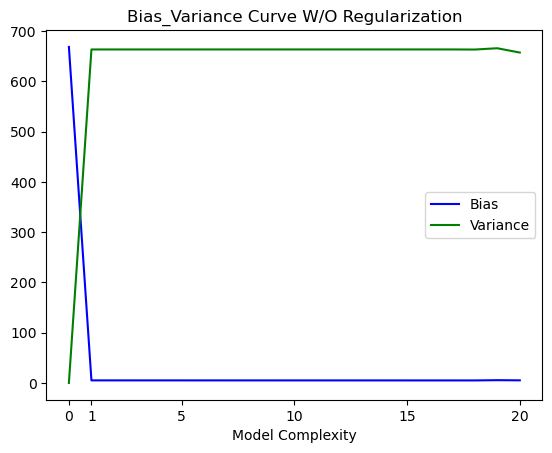

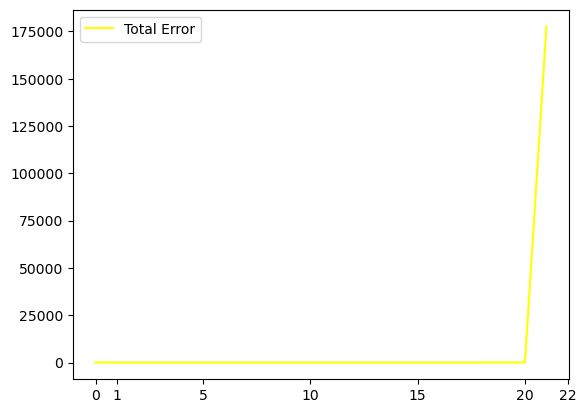

In [ ]:
def l2fit_model(x, y, degree, lamda):
    """
    Fits an overparameterized polynomial model of degree n to the input data.
    
    Args:
    x: ndarray of shape (m, 2) containing the input feature vectors.
    y: ndarray of shape (m, 1) containing the input labels.
    n: integer degree of the polynomial model to fit.
    
    Returns:
    coefficients: ndarray of shape ((n+1)*(n+2)//2, 1) containing the fitted model coefficients.
    """
    
    x_poly = generate_polynomial_features(x, degree)
    I = np.identity(np.shape(x_poly)[1])
    coefficients = inv(x_poly.T @ x_poly +lamda*I) @ x_poly.T @ y
    return coefficients

# Fit the overparameterized model to the training data
result = np.zeros((21,6))
total_error = np.zeros((21,1))

print("\nTraining parameters\n")

for i in range(21):
    coefficients_train = l2fit_model(x_train, y_train, i, 2)   ## choosing the hyperparameter 
    variance, bias, mae, mse = evaluate_model(x_train, y_train, coefficients_train, i) 
    result[i,0] = i
    result[i,1] = variance
    result[i,2] = bias
    result[i,3] = mae
    result[i,4] = mse
    total_error[i] = mse + (np.linalg.norm(coefficients_train))**2
    result[i,5] = total_error[i]
    
param = list(result)
param = [["Model Complexity","Variance","Bias","MSE","MAE", "Total Error"]] + param
print(tabulate(param, headers ='firstrow', tablefmt = 'fancy_outline'))


#Plotting Bias_Variance Curves  

plt.figure()
plt.plot(k,result[:,3], color ='blue', label='Bias')
plt.plot(k,result[:,1], color ='green', label='Variance')
plt.xticks([0, 1, 5, 10, 15, 20])
plt.xlabel("Model Complexity")
plt.title("Bias_Variance Curve W/O Regularization")
plt.legend()
plt.show



# Fit the overparameterized model to the testing data

result_test = np.zeros((22,4))
total_error = np.zeros((22,1))
print("\nTesting parameters\n")

for l in range(22):
    coefficients_test = l2fit_model(x_test, y_test, l, 2)
    variance, bias, mae, mse = evaluate_model(x_test, y_test, coefficients_test, l)  
    result_test[l,0] = l
    result_test[l,1] = mae
    result_test[l,2] = mse
    total_error[l] = mse + (np.linalg.norm(coefficients_test))**2
    result_test[l,3] = total_error[l]
    
param_test = list(result_test)
param_test = [["Model Complexity","MSE","MAE", "Total Error"]] + param_test
print(tabulate(param_test, headers ='firstrow', tablefmt = 'fancy_outline'))

p = np.linspace(0,21,22)
plt.figure()
plt.xticks([0, 1, 5, 10, 15, 20, 22])
plt.plot(p, total_error, color='magenta', label='Total Error')
plt.legend()
plt.show


# L1 Regularization-model1


Training parameters

+--------------------+--------------+----------+---------+---------+---------------+
|   Model Complexity |     Variance |     Bias |     MSE |     MAE |   Total Error |
+====================+==============+==========+=========+=========+===============+
|                  0 |  0           | -3.10157 | 677.855 | 21.7168 |       21.7168 |
+--------------------+--------------+----------+---------+---------+---------------+
|                  1 |  4.68544e-39 | -3.10157 | 677.855 | 21.7168 |       21.7168 |
+--------------------+--------------+----------+---------+---------+---------------+
|                  2 |  1.86978e-36 | -3.10157 | 677.855 | 21.7168 |       21.7168 |
+--------------------+--------------+----------+---------+---------+---------------+
|                  3 |  3.16241e-29 | -3.10157 | 677.855 | 21.7168 |       21.7168 |
+--------------------+--------------+----------+---------+---------+---------------+
|                  4 |  1.8641e-26  | -3.10

C:\Users\yvsdm\AppData\Local\Temp\ipykernel_48504\3149070548.py:22: RuntimeWarning: overflow encountered in square
  cost = np.mean(error**2) + alpha * np.sum(np.abs(coefficients))
C:\Users\yvsdm\AppData\Local\Temp\ipykernel_48504\3149070548.py:23: RuntimeWarning: overflow encountered in multiply
  subgrad = 2 * np.dot(x_poly.T, error) + alpha * np.sign(coefficients)


╒════════════════════╤═════════╤══════════╤═══════════════╕
│   Model Complexity │     MSE │      MAE │   Total Error │
╞════════════════════╪═════════╪══════════╪═══════════════╡
│                  0 │ 696.931 │  22.1842 │       22.1842 │
│                  1 │ 696.931 │  22.1842 │       22.1842 │
│                  2 │ 696.931 │  22.1842 │       22.1842 │
│                  3 │ 696.931 │  22.1842 │       22.1842 │
│                  4 │ 696.931 │  22.1842 │       22.1842 │
│                  5 │ 696.931 │  22.1842 │       22.1842 │
│                  6 │ 696.931 │  22.1842 │       22.1842 │
│                  7 │ 696.929 │  22.1842 │       22.1842 │
│                  8 │ 696.927 │  22.1842 │       22.1842 │
│                  9 │ 581.898 │  20.5699 │       20.5699 │
│                 10 │ 580.093 │  20.5612 │       20.5612 │
│                 11 │ nan     │ nan      │      nan      │
╘════════════════════╧═════════╧══════════╧═══════════════╛


<function matplotlib.pyplot.show(close=None, block=None)>

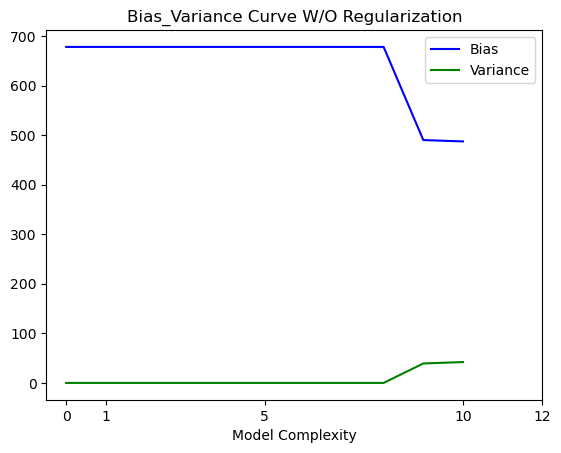

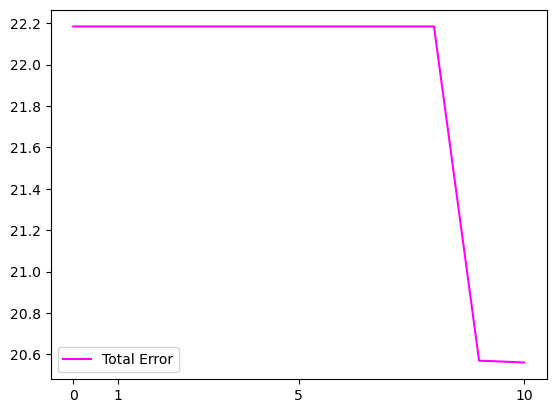

In [ ]:
def l1_fit_model(x, y, degree, alpha):
    """
    Fits a regularized polynomial model of degree n to the input data using L1 regularization.
    
    Args:
    x: ndarray of shape (m, 2) containing the input feature vectors.
    y: ndarray of shape (m, 1) containing the input labels.
    degree: integer degree of the polynomial model to fit.
    alpha: float regularization strength.
    
    Returns:
    coefficients: ndarray of shape ((n+1)*(n+2)//2, 1) containing the fitted model coefficients.
    """
    x_poly = generate_polynomial_features(x, degree)
    m, n = x_poly.shape
    coefficients = np.zeros((n, 1))
    iterations = 1000
    learning_rate = 10**-30
    for i in range(iterations):
        y_est = np.dot(x_poly, coefficients)
        error = y_est - y
        cost = np.mean(error**2) + alpha * np.sum(np.abs(coefficients))
        subgrad = 2 * np.dot(x_poly.T, error) + alpha * np.sign(coefficients)
       # print(subgrad)
        coefficients -= learning_rate * subgrad
        #print(coefficients)
    return coefficients



k =  np.linspace(0,10,11)
# Fit the overparameterized model to the training data
result = np.zeros((11,6))
total_error = np.zeros((11,1))

print("\nTraining parameters\n")

for i in range(11):
    coefficients_train = l1_fit_model(x_train, y_train, i, 10**-3)
    variance, bias, mae, mse = evaluate_model(x_train, y_train, coefficients_train, i)  
    result[i,0] = i
    result[i,1] = variance
    result[i,2] = bias
    result[i,3] = mae
    result[i,4] = mse
    total_error[i] = mse + np.sum(np.abs(coefficients_train))
    result[i,5] = total_error[i]

param = list(result)
param = [["Model Complexity","Variance","Bias","MSE","MAE", "Total Error"]] + param
print(tabulate(param, headers ='firstrow', tablefmt = 'grid'))


#Plotting Bias_Variance Curves  

plt.figure()
plt.plot(k,result[:,3], color ='blue', label='Bias')
plt.plot(k,result[:,1], color ='green', label='Variance')
plt.xticks([0, 1, 5, 10, 12])
plt.xlabel("Model Complexity")
plt.title("Bias_Variance Curve W/O Regularization")
plt.legend()
plt.show



# Fit the overparameterized model to the testing data

result_test = np.zeros((12,4))
total_error = np.zeros((12,1))
print("\nTesting parameters\n")

for l in range(12):
    coefficients_test = l1_fit_model(x_test, y_test, l, 2)
    variance, bias, mae, mse = evaluate_model(x_test, y_test, coefficients_test, l)  
    result_test[l,0] = l
    result_test[l,1] = mae
    result_test[l,2] = mse
    total_error[l] = mse + 2*np.sum(np.absolute(coefficients_test))
    result_test[l,3] = total_error[l]
    
param_test = list(result_test)
param_test = [["Model Complexity","MSE","MAE", "Total Error"]] + param_test
print(tabulate(param_test, headers ='firstrow', tablefmt = 'fancy_outline'))

p = np.linspace(0,11,12)
plt.figure()
plt.xticks([0, 1, 5, 10, 12])
plt.plot(p, total_error, color='magenta', label='Total Error')
plt.legend()
plt.show


# L1 and L2 regularization-model1 


Training parameters

+--------------------+--------------+----------+---------+---------+---------------+
|   Model Complexity |     Variance |     Bias |     MSE |     MAE |   Total Error |
+====================+==============+==========+=========+=========+===============+
|                  0 |  1.38179e-76 | -3.10157 | 677.855 | 21.7168 |       21.7168 |
+--------------------+--------------+----------+---------+---------+---------------+
|                  1 |  4.68544e-39 | -3.10157 | 677.855 | 21.7168 |       21.7168 |
+--------------------+--------------+----------+---------+---------+---------------+
|                  2 |  1.86978e-36 | -3.10157 | 677.855 | 21.7168 |       21.7168 |
+--------------------+--------------+----------+---------+---------+---------------+
|                  3 |  3.16241e-29 | -3.10157 | 677.855 | 21.7168 |       21.7168 |
+--------------------+--------------+----------+---------+---------+---------------+
|                  4 |  1.8641e-26  | -3.10

C:\Users\yvsdm\AppData\Local\Temp\ipykernel_48504\3207566716.py:22: RuntimeWarning: overflow encountered in square
  cost = np.mean(error**2) + alpha * np.sum(np.abs(coefficients))
C:\Users\yvsdm\AppData\Local\Temp\ipykernel_48504\3207566716.py:23: RuntimeWarning: overflow encountered in multiply
  subgrad = 2 * np.dot(x_poly.T, error) + alpha * np.sign(coefficients)  + 2*gamma*coefficients


╒════════════════════╤═════════╤══════════╤═══════════════╕
│   Model Complexity │     MSE │      MAE │   Total Error │
╞════════════════════╪═════════╪══════════╪═══════════════╡
│                  0 │ 696.931 │  22.1842 │       22.1842 │
│                  1 │ 696.931 │  22.1842 │       22.1842 │
│                  2 │ 696.931 │  22.1842 │       22.1842 │
│                  3 │ 696.931 │  22.1842 │       22.1842 │
│                  4 │ 696.931 │  22.1842 │       22.1842 │
│                  5 │ 696.931 │  22.1842 │       22.1842 │
│                  6 │ 696.931 │  22.1842 │       22.1842 │
│                  7 │ 696.929 │  22.1842 │       22.1842 │
│                  8 │ 696.927 │  22.1842 │       22.1842 │
│                  9 │ 581.898 │  20.5699 │       20.5699 │
│                 10 │ 580.093 │  20.5612 │       20.5612 │
│                 11 │ nan     │ nan      │      nan      │
╘════════════════════╧═════════╧══════════╧═══════════════╛


<function matplotlib.pyplot.show(close=None, block=None)>

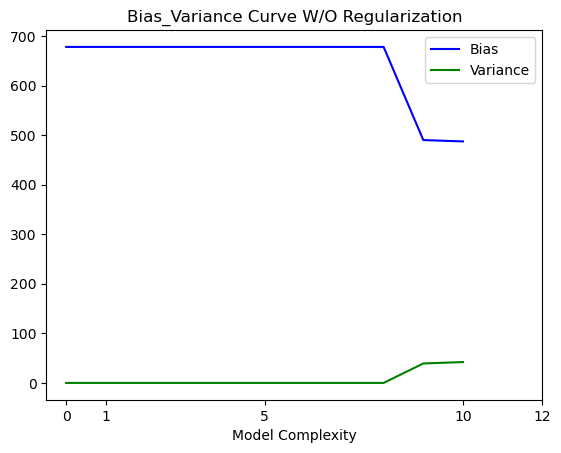

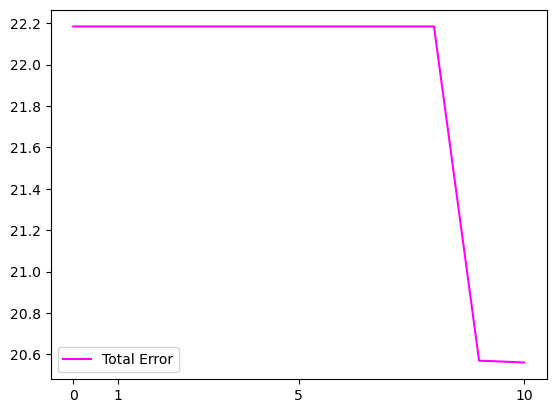

In [ ]:
def l1_l2_fit_model(x, y, degree, alpha, gamma):
    """
    Fits a regularized polynomial model of degree n to the input data using L1 regularization.
    
    Args:
    x: ndarray of shape (m, 2) containing the input feature vectors.
    y: ndarray of shape (m, 1) containing the input labels.
    degree: integer degree of the polynomial model to fit.
    alpha: float regularization strength.
    
    Returns:
    coefficients: ndarray of shape ((n+1)*(n+2)//2, 1) containing the fitted model coefficients.
    """
    x_poly = generate_polynomial_features(x, degree)
    m, n = x_poly.shape
    coefficients = np.zeros((n, 1))
    iterations = 1000
    learning_rate = 10**-30
    for i in range(iterations):
        y_est = np.dot(x_poly, coefficients)
        error = y_est - y
        cost = np.mean(error**2) + alpha * np.sum(np.abs(coefficients))
        subgrad = 2 * np.dot(x_poly.T, error) + alpha * np.sign(coefficients)  + 2*gamma*coefficients
       # print(subgrad)
        coefficients -= learning_rate * subgrad
        #print(coefficients)
    return coefficients

k =  np.linspace(0,10,11)
# Fit the overparameterized model to the training data
result = np.zeros((11,6))
total_error = np.zeros((11,1))

print("\nTraining parameters\n")

for i in range(11):
    coefficients_train = l1_l2_fit_model(x_train, y_train, i, 2, 300)
    variance, bias, mae, mse = evaluate_model(x_train, y_train, coefficients_train, i)  
    result[i,0] = i
    result[i,1] = variance
    result[i,2] = bias
    result[i,3] = mae
    result[i,4] = mse
    total_error[i] = mse + np.sum(np.abs(coefficients_train)) + 300*np.linalg.norm(coefficients_train)
    result[i,5] = total_error[i]

param = list(result)
param = [["Model Complexity","Variance","Bias","MSE","MAE", "Total Error"]] + param
print(tabulate(param, headers ='firstrow', tablefmt = 'grid'))


#Plotting Bias_Variance Curves  

plt.figure()
plt.plot(k,result[:,3], color ='blue', label='Bias')
plt.plot(k,result[:,1], color ='green', label='Variance')
plt.xticks([0, 1, 5, 10, 12])
plt.xlabel("Model Complexity")
plt.title("Bias_Variance Curve W/O Regularization")
plt.legend()
plt.show



# Fit the overparameterized model to the testing data

result_test = np.zeros((12,4))
total_error = np.zeros((12,1))
print("\nTesting parameters\n")

for l in range(12):
    coefficients_test = l1_l2_fit_model(x_test, y_test, l, 2, 300)
    variance, bias, mae, mse = evaluate_model(x_test, y_test, coefficients_test, l)  
    result_test[l,0] = l
    result_test[l,1] = mae
    result_test[l,2] = mse
    total_error[l] = mse + np.sum(np.absolute(coefficients_test)) + 300*np.linalg.norm(coefficients_test)
    result_test[l,3] = total_error[l]
    
param_test = list(result_test)
param_test = [["Model Complexity","MSE","MAE", "Total Error"]] + param_test
print(tabulate(param_test, headers ='firstrow', tablefmt = 'fancy_outline'))

p = np.linspace(0,11,12)
plt.figure()
plt.xticks([0, 1, 5, 10, 12])
plt.plot(p, total_error, color='magenta', label='Total Error')
plt.legend()
plt.show


# Overfitting model w/o regularization-model2


Training parameters

+--------------------+---------------+--------------+---------+----------+
|   Model Complexity |      Variance |         Bias |     MSE |      MAE |
+====================+===============+==============+=========+==========+
|                  0 |   7.88861e-31 | -7.50333e-16 | 668.235 | 21.5864  |
+--------------------+---------------+--------------+---------+----------+
|                  1 | 532.26        | -7.50333e-16 | 135.975 | 10.0212  |
+--------------------+---------------+--------------+---------+----------+
|                  2 | 532.314       | -7.50333e-16 | 135.921 | 10.0199  |
+--------------------+---------------+--------------+---------+----------+
|                  3 | 532.353       | -4.54747e-16 | 135.882 | 10.0167  |
+--------------------+---------------+--------------+---------+----------+
|                  4 | 532.394       | -4.54747e-16 | 135.841 | 10.0129  |
+--------------------+---------------+--------------+---------+----------+
|  

<function matplotlib.pyplot.show(close=None, block=None)>

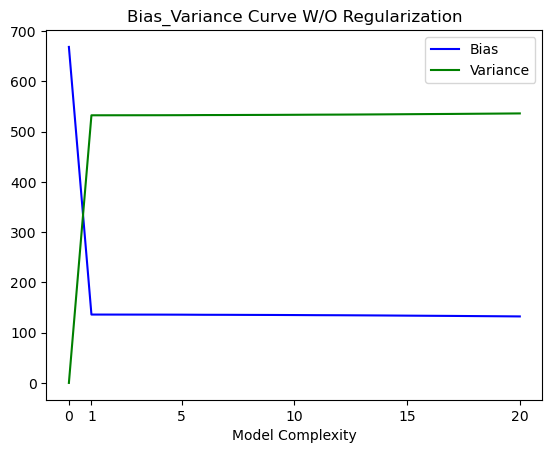

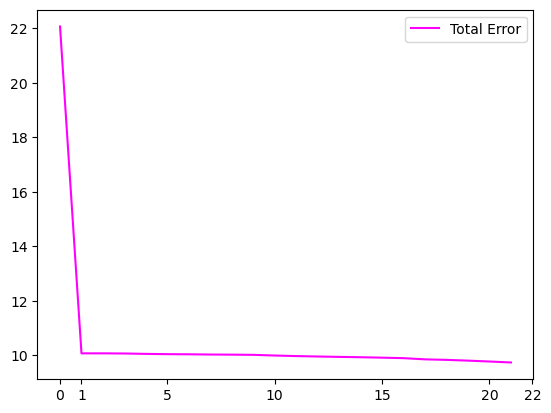

In [ ]:
import numpy as np

def generate_poly_sinusoidal_features(X, n):
    """
    Generates polynomial features of degree n for a 2-dimensional input array X.
    
    Args:
    X: ndarray of shape (m, 2) containing the input data.
    n: integer degree of the polynomial features to generate.
    
    Returns:
    X_poly: ndarray of shape (m, (n+1)*(n+2)//2) containing the polynomial features.
    """
    m = X.shape[0]
    X_poly = np.ones((m, (n+1)*(n+2)//2))
    idx = 0
    for i in range(n+1):
        for j in range(i+1):
            X_poly[:, idx] = (X[:, 0]**(i-j)) * (X[:, 1]**j)
            idx += 1
    for i in range(2, X_poly.shape[1]):
        X_poly[:, i] = np.sin(X_poly[:, i])
    return X_poly
   

def fit_model(x, y, degree):
    """
    Fits an overparameterized polynomial model of degree n to the input data.
    
    Args:
    x: ndarray of shape (m, 2) containing the input feature vectors.
    y: ndarray of shape (m, 1) containing the input labels.
    n: integer degree of the polynomial model to fit.
    
    Returns:
    coefficients: ndarray of shape ((n+1)*(n+2)//2, 1) containing the fitted model coefficients.
    """
    x_poly = generate_poly_sinusoidal_features(x, degree)
    coefficients = inv(x_poly.T @ x_poly) @ x_poly.T @ y
    return coefficients

def evaluate_model(x, y, coefficients, degree):
    """
    Evaluates the performance of the model on the input data using mean absolute error and mean squared error.
    
    Args:
    x: ndarray of shape (m, 2) containing the input feature vectors.
    y: ndarray of shape (m, 1) containing the input labels.
    coefficients: ndarray of shape ((n+1)*(n+2)//2, 1) containing the fitted model coefficients.
    
    Returns:
    mae: float containing the mean absolute error of the model predictions.
    mse: float containing the mean squared error of the model predictions.
    """
    y_est = np.dot(generate_poly_sinusoidal_features(x, degree), coefficients)
    
    bias = np.mean(np.full(np.shape(y_est), np.mean(y_est)) - y)
    mae = np.mean(np.abs(y_est - y))
    mse = np.mean((y_est - y) ** 2)
    variance = np.mean((np.full(np.shape(y_est), np.mean(y_est))-y_est)**2)
    return variance, bias, mse, mae



k =  np.linspace(0,20,21)
# Fit the overparameterized model to the training data
result = np.zeros((21,5))

print("\nTraining parameters\n")

for i in range(21):
    coefficients_train = fit_model(x_train, y_train, i)
    variance, bias, mae, mse = evaluate_model(x_train, y_train, coefficients_train, i)  
    result[i,0] = i
    result[i,1] = variance
    result[i,2] = bias
    result[i,3] = mae
    result[i,4] = mse

param = list(result)
param = [["Model Complexity","Variance","Bias","MSE","MAE"]] + param
print(tabulate(param, headers ='firstrow', tablefmt = 'grid'))


#Plotting Bias_Variance Curves  

plt.figure()
plt.plot(k, result[:,3], color ='blue', label='Bias')
plt.plot(k,result[:,1], color ='green', label='Variance')
plt.xticks([0, 1, 5, 10, 15, 20])
plt.xlabel("Model Complexity")
plt.title("Bias_Variance Curve W/O Regularization")
plt.legend()
plt.show



# Fit the overparameterized model to the testing data

result_test = np.zeros((22,3))
print("\nTesting parameters\n")

for l in range(22):
    coefficients_test = fit_model(x_test, y_test, l)
    variance, bias, mae, mse = evaluate_model(x_test, y_test, coefficients_test, l)  
    result_test[l,0] = l
    result_test[l,1] = mae
    result_test[l,2] = mse

param_test = list(result_test)
param_test = [["Model Complexity","MSE","MAE"]] + param_test
print(tabulate(param_test, headers ='firstrow', tablefmt = 'grid'))

p = np.linspace(0,21,22)
plt.figure()
plt.xticks([0, 1, 5, 10, 15, 20, 22])
plt.plot(p, result_test[:,2], color='magenta', label='Total Error')
plt.legend()
plt.show


# with L2 regularization-model2


Training parameters

╒════════════════════╤═══════════════╤══════════════╤═════════╤══════════╤═══════════════╕
│   Model Complexity │      Variance │         Bias │     MSE │      MAE │   Total Error │
╞════════════════════╪═══════════════╪══════════════╪═════════╪══════════╪═══════════════╡
│                  0 │   1.97215e-31 │ -0.00062019  │ 668.235 │ 21.5864  │       31.2023 │
│                  1 │ 532.258       │ -0.000575837 │ 135.975 │ 10.0212  │       22.561  │
│                  2 │ 532.313       │ -0.000577966 │ 135.921 │ 10.0199  │       22.732  │
│                  3 │ 532.351       │ -0.00057785  │ 135.882 │ 10.0167  │       22.8118 │
│                  4 │ 532.392       │ -0.000577802 │ 135.841 │ 10.0129  │       22.894  │
│                  5 │ 532.495       │ -0.000578    │ 135.738 │ 10.0074  │       23.1017 │
│                  6 │ 532.717       │ -0.000575435 │ 135.516 │  9.99571 │       23.4581 │
│                  7 │ 532.787       │ -0.000575209 │ 135.446 │  9.9

<function matplotlib.pyplot.show(close=None, block=None)>

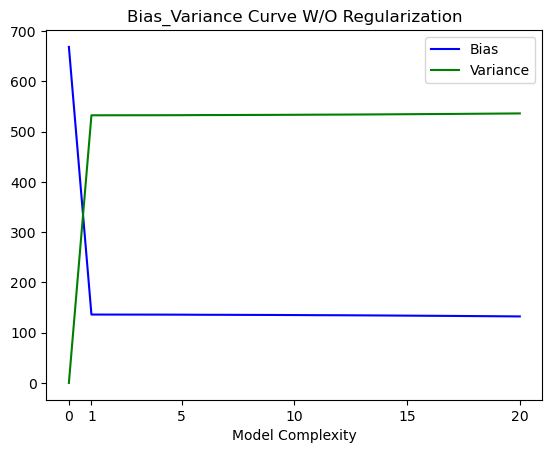

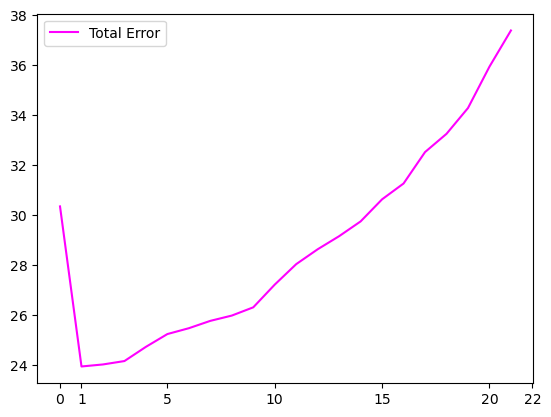

In [ ]:
def l2fit_model(x, y, degree, lamda):
    """
    Fits an overparameterized polynomial model of degree n to the input data.
    
    Args:
    x: ndarray of shape (m, 2) containing the input feature vectors.
    y: ndarray of shape (m, 1) containing the input labels.
    n: integer degree of the polynomial model to fit.
    
    Returns:
    coefficients: ndarray of shape ((n+1)*(n+2)//2, 1) containing the fitted model coefficients.
    """
    
    x_poly = generate_poly_sinusoidal_features(x, degree)
    I = np.identity(np.shape(x_poly)[1])
    coefficients = inv(x_poly.T @ x_poly +lamda*I) @ x_poly.T @ y
    return coefficients

# Fit the overparameterized model to the training data
result = np.zeros((21,6))
total_error = np.zeros((21,1))

print("\nTraining parameters\n")

for i in range(21):
    coefficients_train = l2fit_model(x_train, y_train, i, 2)   ## choosing the hyperparameter 
    variance, bias, mae, mse = evaluate_model(x_train, y_train, coefficients_train, i) 
    result[i,0] = i
    result[i,1] = variance
    result[i,2] = bias
    result[i,3] = mae
    result[i,4] = mse
    total_error[i] = mse + (np.linalg.norm(coefficients_train))**2
    result[i,5] = total_error[i]
    
param = list(result)
param = [["Model Complexity","Variance","Bias","MSE","MAE", "Total Error"]] + param
print(tabulate(param, headers ='firstrow', tablefmt = 'fancy_outline'))


#Plotting Bias_Variance Curves  

plt.figure()
plt.plot(k,result[:,3], color ='blue', label='Bias')
plt.plot(k,result[:,1], color ='green', label='Variance')
plt.xticks([0, 1, 5, 10, 15, 20])
plt.xlabel("Model Complexity")
plt.title("Bias_Variance Curve W/O Regularization")
plt.legend()
plt.show



# Fit the overparameterized model to the testing data

result_test = np.zeros((22,4))
total_error = np.zeros((22,1))
print("\nTesting parameters\n")

for l in range(22):
    coefficients_test = l2fit_model(x_test, y_test, l, 2)
    variance, bias, mae, mse = evaluate_model(x_test, y_test, coefficients_test, l)  
    result_test[l,0] = l
    result_test[l,1] = mae
    result_test[l,2] = mse
    total_error[l] = mse + (np.linalg.norm(coefficients_test))**2
    result_test[l,3] = total_error[l]
    
param_test = list(result_test)
param_test = [["Model Complexity","MSE","MAE", "Total Error"]] + param_test
print(tabulate(param_test, headers ='firstrow', tablefmt = 'fancy_outline'))

p = np.linspace(0,21,22)
plt.figure()
plt.xticks([0, 1, 5, 10, 15, 20, 22])
plt.plot(p, total_error, color='magenta', label='Total Error')
plt.legend()
plt.show

# with L1 Regularization-model2


Training parameters

+--------------------+-------------+----------+---------+---------+---------------+
|   Model Complexity |    Variance |     Bias |     MSE |     MAE |   Total Error |
+====================+=============+==========+=========+=========+===============+
|                  0 | 5.52715e-76 | -3.10157 | 677.855 | 21.7168 |       21.7168 |
+--------------------+-------------+----------+---------+---------+---------------+
|                  1 | 1.51907e-38 | -3.10157 | 677.855 | 21.7168 |       21.7168 |
+--------------------+-------------+----------+---------+---------+---------------+
|                  2 | 1.51907e-38 | -3.10157 | 677.855 | 21.7168 |       21.7168 |
+--------------------+-------------+----------+---------+---------+---------------+
|                  3 | 1.51907e-38 | -3.10157 | 677.855 | 21.7168 |       21.7168 |
+--------------------+-------------+----------+---------+---------+---------------+
|                  4 | 1.51907e-38 | -3.10157 | 677.85

<function matplotlib.pyplot.show(close=None, block=None)>

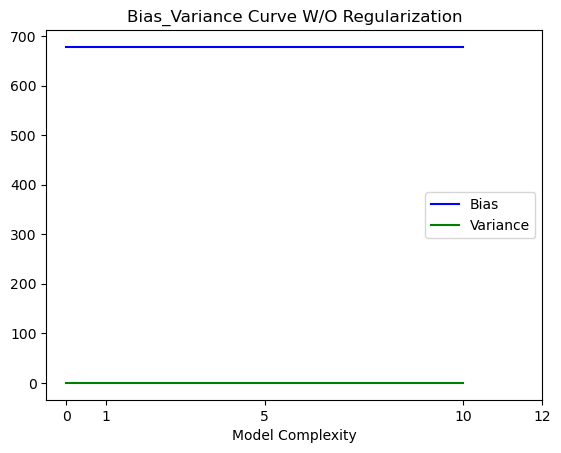

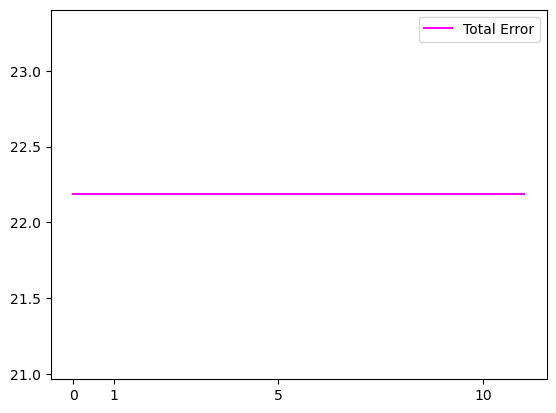

In [ ]:
def l1_fit_model(x, y, degree, alpha):
    """
    Fits a regularized polynomial model of degree n to the input data using L1 regularization.
    
    Args:
    x: ndarray of shape (m, 2) containing the input feature vectors.
    y: ndarray of shape (m, 1) containing the input labels.
    degree: integer degree of the polynomial model to fit.
    alpha: float regularization strength.
    
    Returns:
    coefficients: ndarray of shape ((n+1)*(n+2)//2, 1) containing the fitted model coefficients.
    """
    x_poly = generate_poly_sinusoidal_features(x, degree)
    m, n = x_poly.shape
    coefficients = np.zeros((n, 1))
    iterations = 2000
    learning_rate = 10**-30
    for i in range(iterations):
        y_est = np.dot(x_poly, coefficients)
        error = y_est - y
        cost = np.mean(error**2) + alpha * np.sum(np.abs(coefficients))
        subgrad = 2 * np.dot(x_poly.T, error) + alpha * np.sign(coefficients)
       # print(subgrad)
        coefficients -= learning_rate * subgrad
        #print(coefficients)
    return coefficients



k =  np.linspace(0,10,11)
# Fit the overparameterized model to the training data
result = np.zeros((11,6))
total_error = np.zeros((11,1))

print("\nTraining parameters\n")

for i in range(11):
    coefficients_train = l1_fit_model(x_train, y_train, i, 10**-3)
    variance, bias, mae, mse = evaluate_model(x_train, y_train, coefficients_train, i)  
    result[i,0] = i
    result[i,1] = variance
    result[i,2] = bias
    result[i,3] = mae
    result[i,4] = mse
    total_error[i] = mse + np.sum(np.abs(coefficients_train))
    result[i,5] = total_error[i]

param = list(result)
param = [["Model Complexity","Variance","Bias","MSE","MAE", "Total Error"]] + param
print(tabulate(param, headers ='firstrow', tablefmt = 'grid'))


#Plotting Bias_Variance Curves  

plt.figure()
plt.plot(k,result[:,3], color ='blue', label='Bias')
plt.plot(k,result[:,1], color ='green', label='Variance')
plt.xticks([0, 1, 5, 10, 12])
plt.xlabel("Model Complexity")
plt.title("Bias_Variance Curve W/O Regularization")
plt.legend()
plt.show



# Fit the overparameterized model to the testing data

result_test = np.zeros((12,4))
total_error = np.zeros((12,1))
print("\nTesting parameters\n")

for l in range(12):
    coefficients_test = l1_fit_model(x_test, y_test, l, 2)
    variance, bias, mae, mse = evaluate_model(x_test, y_test, coefficients_test, l)  
    result_test[l,0] = l
    result_test[l,1] = mae
    result_test[l,2] = mse
    total_error[l] = mse + 2*np.sum(np.absolute(coefficients_test))
    result_test[l,3] = total_error[l]
    
param_test = list(result_test)
param_test = [["Model Complexity","MSE","MAE", "Total Error"]] + param_test
print(tabulate(param_test, headers ='firstrow', tablefmt = 'fancy_outline'))

p = np.linspace(0,11,12)
plt.figure()
plt.xticks([0, 1, 5, 10, 12])
plt.plot(p, total_error, color='magenta', label='Total Error')
plt.legend()
plt.show


# with L1 and L2 regularization-model2


Training parameters

+--------------------+-------------+----------+---------+---------+---------------+
|   Model Complexity |    Variance |     Bias |     MSE |     MAE |   Total Error |
+====================+=============+==========+=========+=========+===============+
|                  0 | 1.38179e-76 | -3.10157 | 677.855 | 21.7168 |       21.7168 |
+--------------------+-------------+----------+---------+---------+---------------+
|                  1 | 3.79767e-39 | -3.10157 | 677.855 | 21.7168 |       21.7168 |
+--------------------+-------------+----------+---------+---------+---------------+
|                  2 | 3.79754e-39 | -3.10157 | 677.855 | 21.7168 |       21.7168 |
+--------------------+-------------+----------+---------+---------+---------------+
|                  3 | 4.80375e-39 | -3.10157 | 677.855 | 21.7168 |       21.7168 |
+--------------------+-------------+----------+---------+---------+---------------+
|                  4 | 3.96363e-38 | -3.10157 | 677.85

<function matplotlib.pyplot.show(close=None, block=None)>

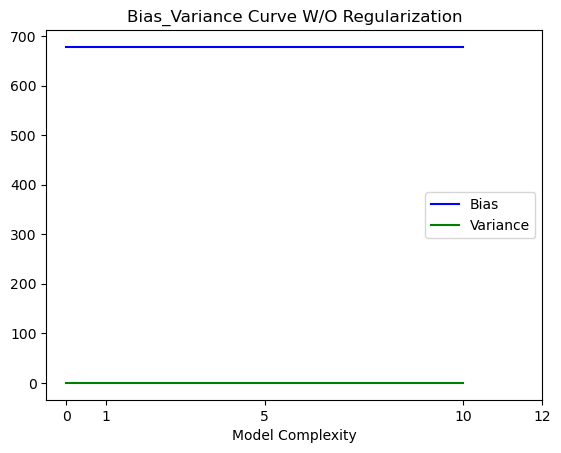

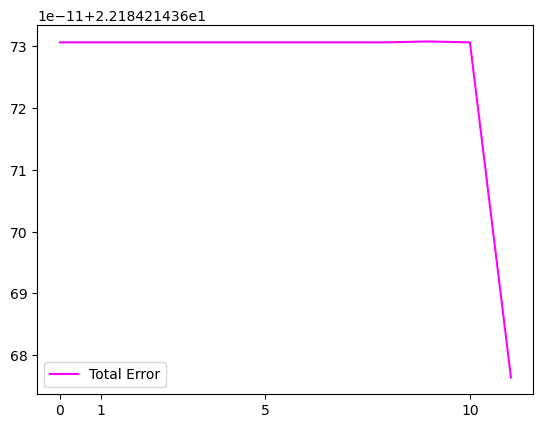

In [ ]:
def l1_l2_fit_model(x, y, degree, alpha, gamma):
    """
    Fits a regularized polynomial model of degree n to the input data using L1 regularization.
    
    Args:
    x: ndarray of shape (m, 2) containing the input feature vectors.
    y: ndarray of shape (m, 1) containing the input labels.
    degree: integer degree of the polynomial model to fit.
    alpha: float regularization strength.
    
    Returns:
    coefficients: ndarray of shape ((n+1)*(n+2)//2, 1) containing the fitted model coefficients.
    """
    x_poly = generate_poly_sinusoidal_features(x, degree)
    m, n = x_poly.shape
    coefficients = np.zeros((n, 1))
    iterations = 1000
    learning_rate = 10**-30
    for i in range(iterations):
        y_est = np.dot(x_poly, coefficients)
        error = y_est - y
        cost = np.mean(error**2) + alpha * np.sum(np.abs(coefficients))
        subgrad = 2 * np.dot(x_poly.T, error) + alpha * np.sign(coefficients)  + 2*gamma*coefficients
       # print(subgrad)
        coefficients -= learning_rate * subgrad
        #print(coefficients)
    return coefficients

k =  np.linspace(0,10,11)
# Fit the overparameterized model to the training data
result = np.zeros((11,6))
total_error = np.zeros((11,1))

print("\nTraining parameters\n")

for i in range(11):
    coefficients_train = l1_l2_fit_model(x_train, y_train, i, 2, 300)
    variance, bias, mae, mse = evaluate_model(x_train, y_train, coefficients_train, i)  
    result[i,0] = i
    result[i,1] = variance
    result[i,2] = bias
    result[i,3] = mae
    result[i,4] = mse
    total_error[i] = mse + np.sum(np.abs(coefficients_train)) + 300*np.linalg.norm(coefficients_train)
    result[i,5] = total_error[i]

param = list(result)
param = [["Model Complexity","Variance","Bias","MSE","MAE", "Total Error"]] + param
print(tabulate(param, headers ='firstrow', tablefmt = 'grid'))


#Plotting Bias_Variance Curves  

plt.figure()
plt.plot(k,result[:,3], color ='blue', label='Bias')
plt.plot(k,result[:,1], color ='green', label='Variance')
plt.xticks([0, 1, 5, 10, 12])
plt.xlabel("Model Complexity")
plt.title("Bias_Variance Curve W/O Regularization")
plt.legend()
plt.show



# Fit the overparameterized model to the testing data

result_test = np.zeros((12,4))
total_error = np.zeros((12,1))
print("\nTesting parameters\n")

for l in range(12):
    coefficients_test = l1_l2_fit_model(x_test, y_test, l, 2, 300)
    variance, bias, mae, mse = evaluate_model(x_test, y_test, coefficients_test, l)  
    result_test[l,0] = l
    result_test[l,1] = mae
    result_test[l,2] = mse
    total_error[l] = mse + np.sum(np.absolute(coefficients_test)) + 300*np.linalg.norm(coefficients_test)
    result_test[l,3] = total_error[l]
    
param_test = list(result_test)
param_test = [["Model Complexity","MSE","MAE", "Total Error"]] + param_test
print(tabulate(param_test, headers ='firstrow', tablefmt = 'fancy_outline'))

p = np.linspace(0,11,12)
plt.figure()
plt.xticks([0, 1, 5, 10, 12])
plt.plot(p, total_error, color='magenta', label='Total Error')
plt.legend()
plt.show

# overfitting model w/o regularization-model3


Training parameters

+--------------------+---------------+--------------+---------+----------+
|   Model Complexity |      Variance |         Bias |     MSE |      MAE |
+====================+===============+==============+=========+==========+
|                  0 |   7.88861e-31 | -7.50333e-16 | 668.235 | 21.5864  |
+--------------------+---------------+--------------+---------+----------+
|                  1 | 532.135       | -4.54747e-16 | 136.1   | 10.0237  |
+--------------------+---------------+--------------+---------+----------+
|                  2 | 532.138       |  8.41283e-16 | 136.097 | 10.0236  |
+--------------------+---------------+--------------+---------+----------+
|                  3 | 532.153       | -1.54614e-15 | 136.082 | 10.0233  |
+--------------------+---------------+--------------+---------+----------+
|                  4 | 532.169       | -4.63388e-14 | 136.066 | 10.0215  |
+--------------------+---------------+--------------+---------+----------+
|  

<function matplotlib.pyplot.show(close=None, block=None)>

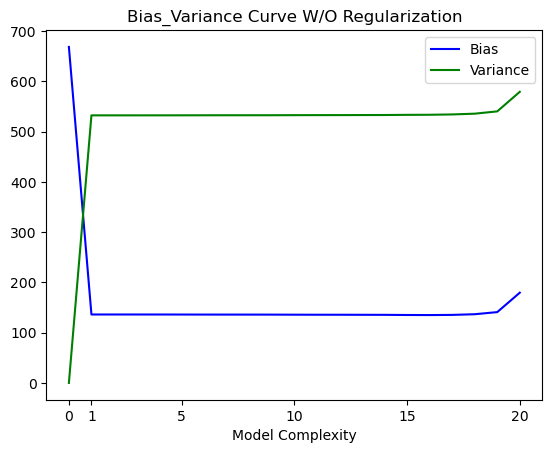

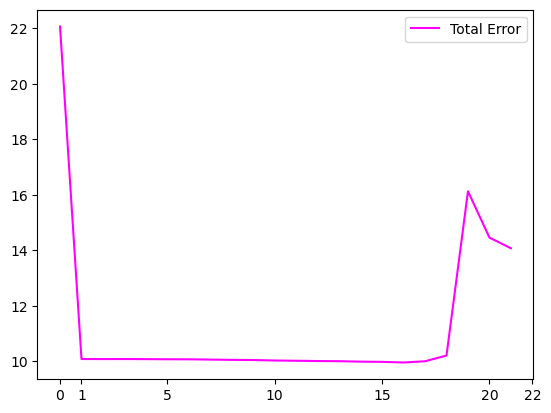

In [ ]:
def generate_poly_expo_features(X, n):
    """
    Generates polynomial features of degree n for a 2-dimensional input array X.
    
    Args:
    X: ndarray of shape (m, 2) containing the input data.
    n: integer degree of the polynomial features to generate.
    
    Returns:
    X_poly: ndarray of shape (m, (n+1)*(n+2)//2) containing the polynomial features.
    """
    m = X.shape[0]
    X_poly = np.ones((m, (n+1)*(n+2)//2))
    idx = 0
    for i in range(n+1):
        for j in range(i+1):
            X_poly[:, idx] = (X[:, 0]**(i-j)) * (X[:, 1]**j)
            idx += 1
    for i in range(2, X_poly.shape[1]):
        X_poly[:, i] = np.exp(-np.absolute(X_poly[:, i]))
    return X_poly
   

def fit_model(x, y, degree):
    """
    Fits an overparameterized polynomial model of degree n to the input data.
    
    Args:
    x: ndarray of shape (m, 2) containing the input feature vectors.
    y: ndarray of shape (m, 1) containing the input labels.
    n: integer degree of the polynomial model to fit.
    
    Returns:
    coefficients: ndarray of shape ((n+1)*(n+2)//2, 1) containing the fitted model coefficients.
    """
    x_poly = generate_poly_expo_features(x, degree)
    coefficients = inv(x_poly.T @ x_poly) @ x_poly.T @ y
    return coefficients

def evaluate_model(x, y, coefficients, degree):
    """
    Evaluates the performance of the model on the input data using mean absolute error and mean squared error.
    
    Args:
    x: ndarray of shape (m, 2) containing the input feature vectors.
    y: ndarray of shape (m, 1) containing the input labels.
    coefficients: ndarray of shape ((n+1)*(n+2)//2, 1) containing the fitted model coefficients.
    
    Returns:
    mae: float containing the mean absolute error of the model predictions.
    mse: float containing the mean squared error of the model predictions.
    """
    y_est = np.dot(generate_poly_expo_features(x, degree), coefficients)
    
    bias = np.mean(np.full(np.shape(y_est), np.mean(y_est)) - y)
    mae = np.mean(np.abs(y_est - y))
    mse = np.mean((y_est - y) ** 2)
    variance = np.mean((np.full(np.shape(y_est), np.mean(y_est))-y_est)**2)
    return variance, bias, mse, mae



k =  np.linspace(0,20,21)
# Fit the overparameterized model to the training data
result = np.zeros((21,5))

print("\nTraining parameters\n")

for i in range(21):
    coefficients_train = fit_model(x_train, y_train, i)
    variance, bias, mae, mse = evaluate_model(x_train, y_train, coefficients_train, i)  
    result[i,0] = i
    result[i,1] = variance
    result[i,2] = bias
    result[i,3] = mae
    result[i,4] = mse

param = list(result)
param = [["Model Complexity","Variance","Bias","MSE","MAE"]] + param
print(tabulate(param, headers ='firstrow', tablefmt = 'grid'))


#Plotting Bias_Variance Curves  

plt.figure()
plt.plot(k, result[:,3], color ='blue', label='Bias')
plt.plot(k,result[:,1], color ='green', label='Variance')
plt.xticks([0, 1, 5, 10, 15, 20])
plt.xlabel("Model Complexity")
plt.title("Bias_Variance Curve W/O Regularization")
plt.legend()
plt.show



# Fit the overparameterized model to the testing data

result_test = np.zeros((22,3))
print("\nTesting parameters\n")

for l in range(22):
    coefficients_test = fit_model(x_test, y_test, l)
    variance, bias, mae, mse = evaluate_model(x_test, y_test, coefficients_test, l)  
    result_test[l,0] = l
    result_test[l,1] = mae
    result_test[l,2] = mse

param_test = list(result_test)
param_test = [["Model Complexity","MSE","MAE"]] + param_test
print(tabulate(param_test, headers ='firstrow', tablefmt = 'grid'))

p = np.linspace(0,21,22)
plt.figure()
plt.xticks([0, 1, 5, 10, 15, 20, 22])
plt.plot(p, result_test[:,2], color='magenta', label='Total Error')
plt.legend()
plt.show


# L2 regularization-model3


Training parameters

╒════════════════════╤═══════════════╤══════════════╤═════════╤═════════╤═══════════════╕
│   Model Complexity │      Variance │         Bias │     MSE │     MAE │   Total Error │
╞════════════════════╪═══════════════╪══════════════╪═════════╪═════════╪═══════════════╡
│                  0 │   1.97215e-31 │ -0.00062019  │ 668.235 │ 21.5864 │       31.2023 │
│                  1 │ 532.134       │ -0.000572703 │ 136.1   │ 10.0237 │       22.3078 │
│                  2 │ 532.136       │ -0.000576239 │ 136.097 │ 10.0236 │       22.5809 │
│                  3 │ 532.143       │ -0.00057795  │ 136.085 │ 10.0233 │       35.5613 │
│                  4 │ 532.151       │ -0.000578746 │ 136.076 │ 10.0227 │       40.1426 │
│                  5 │ 532.154       │ -0.000578396 │ 136.056 │ 10.0221 │       79.1235 │
│                  6 │ 532.177       │ -0.000578154 │ 136.02  │ 10.02   │      113.115  │
│                  7 │ 532.205       │ -0.000578016 │ 135.989 │ 10.0175 │     

<function matplotlib.pyplot.show(close=None, block=None)>

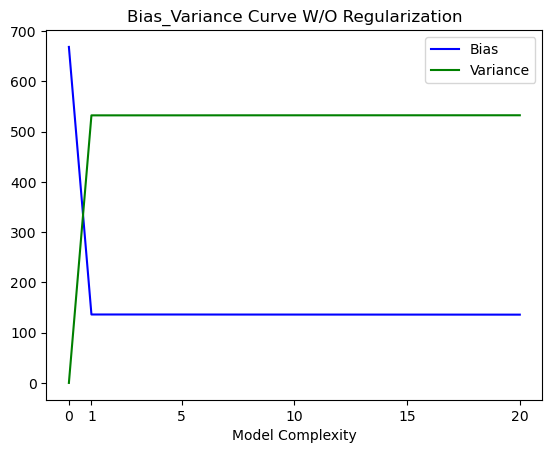

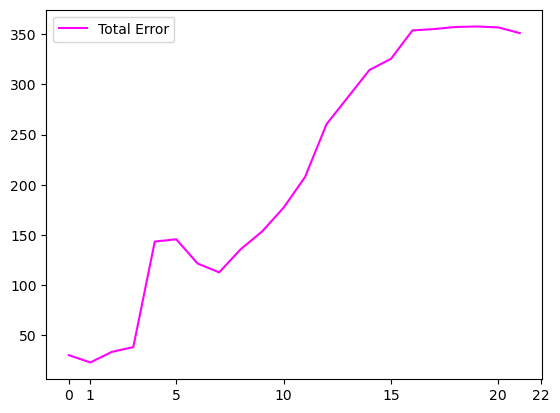

In [ ]:
def l2fit_model(x, y, degree, lamda):
    """
    Fits an overparameterized polynomial model of degree n to the input data.
    
    Args:
    x: ndarray of shape (m, 2) containing the input feature vectors.
    y: ndarray of shape (m, 1) containing the input labels.
    n: integer degree of the polynomial model to fit.
    
    Returns:
    coefficients: ndarray of shape ((n+1)*(n+2)//2, 1) containing the fitted model coefficients.
    """
    
    x_poly = generate_poly_expo_features(x, degree)
    I = np.identity(np.shape(x_poly)[1])
    coefficients = inv(x_poly.T @ x_poly +lamda*I) @ x_poly.T @ y
    return coefficients

# Fit the overparameterized model to the training data
result = np.zeros((21,6))
total_error = np.zeros((21,1))

print("\nTraining parameters\n")

for i in range(21):
    coefficients_train = l2fit_model(x_train, y_train, i, 2)   ## choosing the hyperparameter 
    variance, bias, mae, mse = evaluate_model(x_train, y_train, coefficients_train, i) 
    result[i,0] = i
    result[i,1] = variance
    result[i,2] = bias
    result[i,3] = mae
    result[i,4] = mse
    total_error[i] = mse + (np.linalg.norm(coefficients_train))**2
    result[i,5] = total_error[i]
    
param = list(result)
param = [["Model Complexity","Variance","Bias","MSE","MAE", "Total Error"]] + param
print(tabulate(param, headers ='firstrow', tablefmt = 'fancy_outline'))


#Plotting Bias_Variance Curves  

plt.figure()
plt.plot(k,result[:,3], color ='blue', label='Bias')
plt.plot(k,result[:,1], color ='green', label='Variance')
plt.xticks([0, 1, 5, 10, 15, 20])
plt.xlabel("Model Complexity")
plt.title("Bias_Variance Curve Regularization")
plt.legend()
plt.show



# Fit the overparameterized model to the testing data

result_test = np.zeros((22,4))
total_error = np.zeros((22,1))
print("\nTesting parameters\n")

for l in range(22):
    coefficients_test = l2fit_model(x_test, y_test, l, 2)
    variance, bias, mae, mse = evaluate_model(x_test, y_test, coefficients_test, l)  
    result_test[l,0] = l
    result_test[l,1] = mae
    result_test[l,2] = mse
    total_error[l] = mse + (np.linalg.norm(coefficients_test))**2
    result_test[l,3] = total_error[l]
    
param_test = list(result_test)
param_test = [["Model Complexity","MSE","MAE", "Total Error"]] + param_test
print(tabulate(param_test, headers ='firstrow', tablefmt = 'fancy_outline'))

p = np.linspace(0,21,22)
plt.figure()
plt.xticks([0, 1, 5, 10, 15, 20, 22])
plt.plot(p, total_error, color='magenta', label='Total Error')
plt.legend()
plt.show

# with L1 Regularization-model3


Training parameters

+--------------------+-------------+----------+---------+---------+---------------+
|   Model Complexity |    Variance |     Bias |     MSE |     MAE |   Total Error |
+====================+=============+==========+=========+=========+===============+
|                  0 | 8.84344e-75 | -3.10157 | 677.855 | 21.7168 |       21.7168 |
+--------------------+-------------+----------+---------+---------+---------------+
|                  1 | 3.79766e-37 | -3.10157 | 677.855 | 21.7168 |       21.7168 |
+--------------------+-------------+----------+---------+---------+---------------+
|                  2 | 3.79766e-37 | -3.10157 | 677.855 | 21.7168 |       21.7168 |
+--------------------+-------------+----------+---------+---------+---------------+
|                  3 | 3.79766e-37 | -3.10157 | 677.855 | 21.7168 |       21.7168 |
+--------------------+-------------+----------+---------+---------+---------------+
|                  4 | 3.79766e-37 | -3.10157 | 677.85

<function matplotlib.pyplot.show(close=None, block=None)>

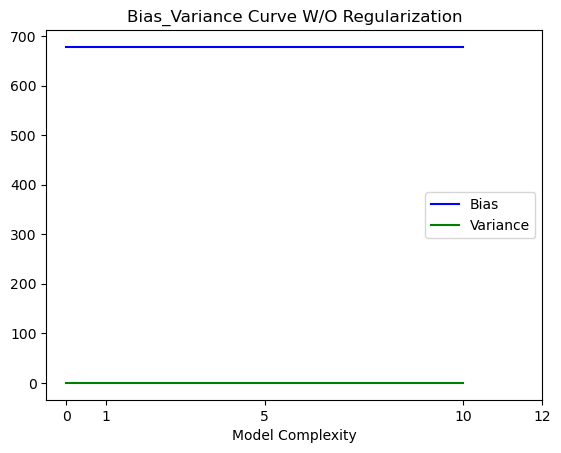

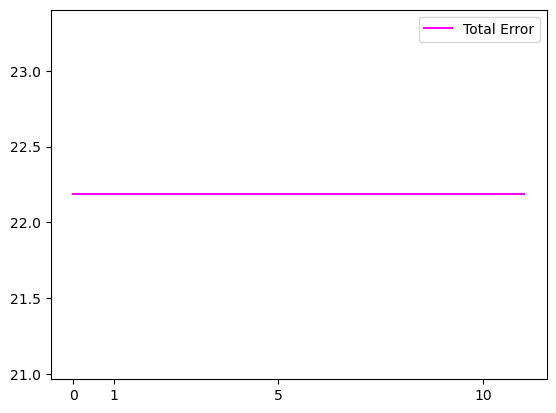

In [ ]:
def l1_fit_model(x, y, degree, alpha):
    """
    Fits a regularized polynomial model of degree n to the input data using L1 regularization.
    
    Args:
    x: ndarray of shape (m, 2) containing the input feature vectors.
    y: ndarray of shape (m, 1) containing the input labels.
    degree: integer degree of the polynomial model to fit.
    alpha: float regularization strength.
    
    Returns:
    coefficients: ndarray of shape ((n+1)*(n+2)//2, 1) containing the fitted model coefficients.
    """
    x_poly = generate_poly_expo_features(x, degree)
    m, n = x_poly.shape
    coefficients = np.zeros((n, 1))
    iterations = 10000
    learning_rate = 10**-30
    for i in range(iterations):
        y_est = np.dot(x_poly, coefficients)
        error = y_est - y
        cost = np.mean(error**2) + alpha * np.sum(np.abs(coefficients))
        subgrad = 2 * np.dot(x_poly.T, error) + alpha * np.sign(coefficients)
       # print(subgrad)
        coefficients -= learning_rate * subgrad
        #print(coefficients)
    return coefficients



k =  np.linspace(0,10,11)
# Fit the overparameterized model to the training data
result = np.zeros((11,6))
total_error = np.zeros((11,1))

print("\nTraining parameters\n")

for i in range(11):
    coefficients_train = l1_fit_model(x_train, y_train, i, 10)
    variance, bias, mae, mse = evaluate_model(x_train, y_train, coefficients_train, i)  
    result[i,0] = i
    result[i,1] = variance
    result[i,2] = bias
    result[i,3] = mae
    result[i,4] = mse
    total_error[i] = mse + np.sum(np.abs(coefficients_train))
    result[i,5] = total_error[i]

param = list(result)
param = [["Model Complexity","Variance","Bias","MSE","MAE", "Total Error"]] + param
print(tabulate(param, headers ='firstrow', tablefmt = 'grid'))


#Plotting Bias_Variance Curves  

plt.figure()
plt.plot(k,result[:,3], color ='blue', label='Bias')
plt.plot(k,result[:,1], color ='green', label='Variance')
plt.xticks([0, 1, 5, 10, 12])
plt.xlabel("Model Complexity")
plt.title("Bias_Variance Curve Regularization")
plt.legend()
plt.show



# Fit the overparameterized model to the testing data

result_test = np.zeros((12,4))
total_error = np.zeros((12,1))
print("\nTesting parameters\n")

for l in range(12):
    coefficients_test = l1_fit_model(x_test, y_test, l, 2)
    variance, bias, mae, mse = evaluate_model(x_test, y_test, coefficients_test, l)  
    result_test[l,0] = l
    result_test[l,1] = mae
    result_test[l,2] = mse
    total_error[l] = mse + 2*np.sum(np.absolute(coefficients_test))
    result_test[l,3] = total_error[l]
    
param_test = list(result_test)
param_test = [["Model Complexity","MSE","MAE", "Total Error"]] + param_test
print(tabulate(param_test, headers ='firstrow', tablefmt = 'fancy_outline'))

p = np.linspace(0,11,12)
plt.figure()
plt.xticks([0, 1, 5, 10, 12])
plt.plot(p, total_error, color='magenta', label='Total Error')
plt.legend()
plt.show


# with L1 and L2 regularization-model3



Training parameters

+--------------------+-------------+----------+---------+---------+---------------+
|   Model Complexity |    Variance |     Bias |     MSE |     MAE |   Total Error |
+====================+=============+==========+=========+=========+===============+
|                  0 | 1.38179e-76 | -3.10157 | 677.855 | 21.7168 |       21.7168 |
+--------------------+-------------+----------+---------+---------+---------------+
|                  1 | 3.79767e-39 | -3.10157 | 677.855 | 21.7168 |       21.7168 |
+--------------------+-------------+----------+---------+---------+---------------+
|                  2 | 3.79767e-39 | -3.10157 | 677.855 | 21.7168 |       21.7168 |
+--------------------+-------------+----------+---------+---------+---------------+
|                  3 | 3.79767e-39 | -3.10157 | 677.855 | 21.7168 |       21.7168 |
+--------------------+-------------+----------+---------+---------+---------------+
|                  4 | 3.79767e-39 | -3.10157 | 677.85

<function matplotlib.pyplot.show(close=None, block=None)>

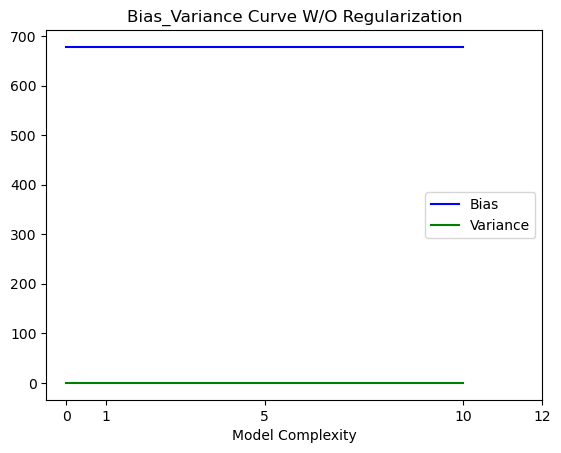

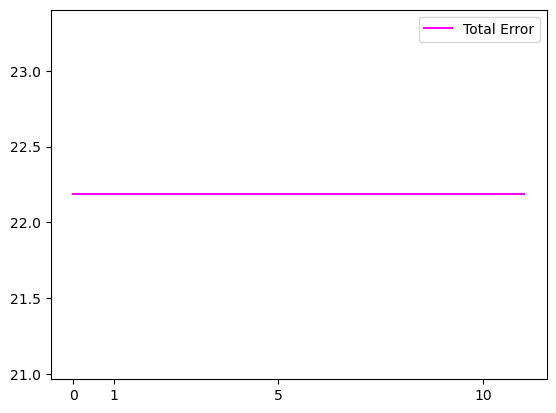

In [ ]:
def l1_l2_fit_model(x, y, degree, alpha, gamma):
    """
    Fits a regularized polynomial model of degree n to the input data using L1 regularization.
    
    Args:
    x: ndarray of shape (m, 2) containing the input feature vectors.
    y: ndarray of shape (m, 1) containing the input labels.
    degree: integer degree of the polynomial model to fit.
    alpha: float regularization strength.
    
    Returns:
    coefficients: ndarray of shape ((n+1)*(n+2)//2, 1) containing the fitted model coefficients.
    """
    x_poly = generate_poly_expo_features(x, degree)
    m, n = x_poly.shape
    coefficients = np.zeros((n, 1))
    iterations = 10000
    learning_rate = 10**-30
    for i in range(iterations):
        y_est = np.dot(x_poly, coefficients)
        error = y_est - y
        cost = np.mean(error**2) + alpha * np.sum(np.abs(coefficients))
        subgrad = 2 * np.dot(x_poly.T, error) + alpha * np.sign(coefficients)  + 2*gamma*coefficients
       # print(subgrad)
        coefficients -= learning_rate * subgrad
        #print(coefficients)
    return coefficients

k =  np.linspace(0,10,11)
# Fit the overparameterized model to the training data
result = np.zeros((11,6))
total_error = np.zeros((11,1))

print("\nTraining parameters\n")

for i in range(11):
    coefficients_train = l1_l2_fit_model(x_train, y_train, i, 2, 300)
    variance, bias, mae, mse = evaluate_model(x_train, y_train, coefficients_train, i)  
    result[i,0] = i
    result[i,1] = variance
    result[i,2] = bias
    result[i,3] = mae
    result[i,4] = mse
    total_error[i] = mse + np.sum(np.abs(coefficients_train)) + 300*np.linalg.norm(coefficients_train)
    result[i,5] = total_error[i]

param = list(result)
param = [["Model Complexity","Variance","Bias","MSE","MAE", "Total Error"]] + param
print(tabulate(param, headers ='firstrow', tablefmt = 'grid'))


#Plotting Bias_Variance Curves  

plt.figure()
plt.plot(k,result[:,3], color ='blue', label='Bias')
plt.plot(k,result[:,1], color ='green', label='Variance')
plt.xticks([0, 1, 5, 10, 12])
plt.xlabel("Model Complexity")
plt.title("Bias_Variance Curve Regularization")
plt.legend()
plt.show



# Fit the overparameterized model to the testing data

result_test = np.zeros((12,4))
total_error = np.zeros((12,1))
print("\nTesting parameters\n")

for l in range(12):
    coefficients_test = l1_l2_fit_model(x_test, y_test, l, 2, 300)
    variance, bias, mae, mse = evaluate_model(x_test, y_test, coefficients_test, l)  
    result_test[l,0] = l
    result_test[l,1] = mae
    result_test[l,2] = mse
    total_error[l] = mse + np.sum(np.absolute(coefficients_test)) + 300*np.linalg.norm(coefficients_test)
    result_test[l,3] = total_error[l]
    
param_test = list(result_test)
param_test = [["Model Complexity","MSE","MAE", "Total Error"]] + param_test
print(tabulate(param_test, headers ='firstrow', tablefmt = 'fancy_outline'))

p = np.linspace(0,11,12)
plt.figure()
plt.xticks([0, 1, 5, 10, 12])
plt.plot(p, total_error, color='magenta', label='Total Error')
plt.legend()
plt.show

# INFERENCES

In [ ]:
1. In our experiment, we used linear regression with a polynomial kernel function but were unable to overfit
even with a small subset of the data. However, when we added cross-terms to the polynomial kernel function, 
we achieved overfitting of the entire dataset with a sufficiently high degree polynomial.

2. Steepest gradient descent was employed with exact line search though perfect convergence could not be attained even after very huge 
number of iterations. So, the gradient descent was prematurely stopped and the weights were used in case of L1 and Elastic Net
which resulted in almost constant errors even as the model complexity increased.

3. Furthermore, we found that L1 regularization had a greater impact on the weights of the model compared to
L2 regularization. This is because L1 regularization tends to push the weights towards zero, resulting in 
sparse solutions, while L2 regularization tries to keep the weights small but non-zero. In contrast, elastic net
regularization had a relatively lower impact on the model's performance, as it combines both L1 and L2 regularization
and may not provide a significant advantage in cases where L1 or L2 regularization alone are already effective. However,
the hyperparameters for elastic net regularization, such as the ratio of L1 and L2 regularization strengths, need to be
carefully tuned for optimal performance.

3. It can be observed that in all the 3 models the best performance was depicted by model 2 with L2 regularization. The possible 
reason behind this might be the extra sinusoidal terms which might be capturing the little variation in data present. Also model 
3 with L2 regularization depicted similar results.

# Q4

In [42]:
Kmnist = np.loadtxt('/content/drive/MyDrive/train.csv',delimiter = ',')
X_kmnist = Kmnist[:,0:-1] 
print(X_kmnist.shape)

(60000, 784)


In [43]:
y_kmnist = Kmnist[:,784].astype(int)
print(y_kmnist)

[0 1 2 ... 7 8 9]


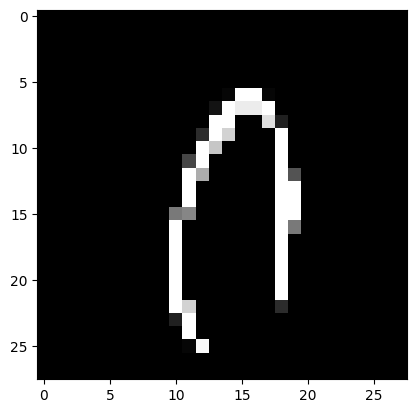

In [44]:
img = X_kmnist[1].reshape((28,28))
pyplt.imshow(img, cmap='gray')

In [6]:
def split_data(X,y,i):
   np.random.seed(42)
   indices = np.random.permutation(X.shape[0])

# Use the first 80% of the shuffled indices for training and the rest for testing
   train_indices, test_indices = indices[:int(i * len(indices))], indices[int(i * len(indices)):]

# Use the shuffled indices to split the data into training and testing sets
   X_train, X_test = X[train_indices], X[test_indices]
   y_train, y_test = y[train_indices], y[test_indices]
   return X_train,y_train,X_test,y_test

In [45]:
X_train,y_train,X_test,y_test = split_data(X_kmnist,y_kmnist,0.7)

In [46]:
print(X_train.shape,X_test.shape,y_test.shape)

(42000, 784) (18000, 784) (18000,)


In [26]:
def minmaxNormalize(X):
    X_norm = np.zeros(X.shape)
    for i in range(X.shape[1]):
        if np.max(X[:,i]) != 0:
            X_norm[:,i] = (X[:,i] - np.min(X[:,i])) / (np.max(X[:,i]) - np.min(X[:,i]))
    return X_norm
    

In [25]:
def one_hot(Y):
      one_hot_Y = np.zeros((Y.size, Y.max() + 1))
      one_hot_Y[np.arange(Y.size), Y] = 1
      one_hot_Y = one_hot_Y
      return one_hot_Y 

In [47]:
y_train =  one_hot(y_train)


In [48]:
print(y_train.shape)

(42000, 10)


In [49]:
import numpy as np

class NeuralNetwork1:
    def __init__(self, input_size, hidden_sizes, output_size):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.weights = [np.random.randn(input_size, hidden_sizes[0])]
        self.biases = [np.zeros((1, hidden_sizes[0]))]
        
        for i in range(1, len(hidden_sizes)):
            self.weights.append(np.random.randn(hidden_sizes[i-1], hidden_sizes[i]))
            self.biases.append(np.zeros((1, hidden_sizes[i])))
        
        self.weights.append(np.random.randn(hidden_sizes[-1], output_size))
        self.biases.append(np.zeros((1, output_size)))
    
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def softmax(self, x):
        exps = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exps / np.sum(exps, axis=1, keepdims=True)
    
  
    def train(self, x, y,  loss_func, learning_rate=0.1, epochs=1000):

        for epoch in range(epochs):
            a = x
            zs = []
            activations = [a]
            for i in range(len(self.weights)):
                z = np.dot(a, self.weights[i]) + self.biases[i]
                zs.append(z)
                a = self.sigmoid(z) if i < len(self.weights)-1 else self.softmax(z)
                activations.append(a)
            
            if(loss_func == 1):
              loss = np.mean(np.square(y - a))
              pred_labels = np.argmax(a, axis=1)
              true_labels = np.argmax(y, axis=1)
              accuracy = np.mean(pred_labels == true_labels)
              delta = (a - y) / y.shape[0]
              delta = 2 * delta
              deltas = [delta]
            
            elif (loss_func == 2):
              loss = -np.mean(y*np.log(a))
              pred_labels = np.argmax(a, axis=1)
              true_labels = np.argmax(y, axis=1)
              accuracy = np.mean(pred_labels == true_labels)
            
            # Backpropagation
              delta = (a - y) / y.shape[0]
              deltas = [delta]
            
            for i in range(len(self.weights)-1, 0, -1):
                delta = np.dot(delta, self.weights[i].T) * (activations[i] * (1 - activations[i]))
                deltas.insert(0, delta)

            if (epoch % 50 == 0 and accuracy*100 < 90):
              learning_rate = learning_rate * 1.2

          

            for i in range(len(self.weights)):
                self.weights[i] -= learning_rate * np.dot(activations[i].T, deltas[i])
                self.biases[i] -= learning_rate * np.sum(deltas[i], axis=0, keepdims=True)
      
            if epoch % 10 == 0:
                print(f"Epoch {epoch} - Loss: {loss:.4f} - Accuracy: {accuracy*100:.4f}")

    def predict(self, x):
      a = x
      for i in range(len(self.weights)):
        z = np.dot(a, self.weights[i]) + self.biases[i]
        a = self.sigmoid(z) if i < len(self.weights)-1 else self.softmax(z)
      return np.argmax(a, axis=1)

## Setting 1

In [ ]:
nn = NeuralNetwork1(input_size=784, hidden_sizes=[300,100,50], output_size=10)

In [68]:
nn.train(X_train/255,y_train,loss_func=1) # loss_func = 1 is squared error loss

Epoch 0 - Loss: 0.1687 - Accuracy: 9.9500
Epoch 10 - Loss: 0.0967 - Accuracy: 18.0714
Epoch 20 - Loss: 0.0896 - Accuracy: 23.3048
Epoch 30 - Loss: 0.0858 - Accuracy: 27.0643
Epoch 40 - Loss: 0.0826 - Accuracy: 30.4881
Epoch 50 - Loss: 0.0798 - Accuracy: 33.9190
Epoch 60 - Loss: 0.0769 - Accuracy: 37.2238
Epoch 70 - Loss: 0.0741 - Accuracy: 40.4190
Epoch 80 - Loss: 0.0715 - Accuracy: 43.2929
Epoch 90 - Loss: 0.0691 - Accuracy: 45.9452
Epoch 100 - Loss: 0.0667 - Accuracy: 48.2952
Epoch 110 - Loss: 0.0643 - Accuracy: 50.6476
Epoch 120 - Loss: 0.0621 - Accuracy: 52.8571
Epoch 130 - Loss: 0.0600 - Accuracy: 54.7452
Epoch 140 - Loss: 0.0581 - Accuracy: 56.5357
Epoch 150 - Loss: 0.0563 - Accuracy: 58.0881
Epoch 160 - Loss: 0.0545 - Accuracy: 59.6929
Epoch 170 - Loss: 0.0529 - Accuracy: 61.1524
Epoch 180 - Loss: 0.0513 - Accuracy: 62.5190
Epoch 190 - Loss: 0.0499 - Accuracy: 63.7095
Epoch 200 - Loss: 0.0485 - Accuracy: 64.9095
Epoch 210 - Loss: 0.0472 - Accuracy: 66.0619
Epoch 220 - Loss: 0.04

In [32]:
def get_f1scores(y_actual, y_pred):

  f1_scores = []
  for c in np.unique(y_actual):
    
    tp = np.sum((y_actual == c) & (y_pred == c))
    fp = np.sum((y_actual != c) & (y_pred == c))
    fn = np.sum((y_actual == c) & (y_pred != c))
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * (precision * recall) / (precision + recall)
    f1_scores.append(f1)
    print(f'Class {c}: F1 score = {f1:.4f}')

In [69]:
y_pred = nn.predict(X_test/255)
print('The accuracy of Neural network with setting 1 with squared error loss is :',np.mean(y_pred == y_test))
get_f1scores(y_test,y_pred)

The accuracy of Neural network with setting 1 with squared error loss is : 0.8850555555555556
Class 0: F1 score = 0.8956
Class 1: F1 score = 0.9239
Class 2: F1 score = 0.9419
Class 3: F1 score = 0.8413
Class 4: F1 score = 0.8731
Class 5: F1 score = 0.8830
Class 6: F1 score = 0.8767
Class 7: F1 score = 0.8016
Class 8: F1 score = 0.9041
Class 9: F1 score = 0.9066


In [51]:
nn = NeuralNetwork1(input_size=784, hidden_sizes=[300,100,50], output_size=10)
nn.train(X_train/255,y_train,loss_func=2) # loss_func = 2 is cross entropy loss
y_pred = nn.predict(X_test/255)


Epoch 0 - Loss: 1.0419 - Accuracy: 9.0976
Epoch 10 - Loss: 0.3898 - Accuracy: 13.7810
Epoch 20 - Loss: 0.2791 - Accuracy: 18.5405
Epoch 30 - Loss: 0.2534 - Accuracy: 21.0500
Epoch 40 - Loss: 0.2402 - Accuracy: 23.3000
Epoch 50 - Loss: 0.2289 - Accuracy: 25.6429
Epoch 60 - Loss: 0.2171 - Accuracy: 28.2857
Epoch 70 - Loss: 0.2071 - Accuracy: 30.7762
Epoch 80 - Loss: 0.1985 - Accuracy: 33.0024
Epoch 90 - Loss: 0.1910 - Accuracy: 35.1595
Epoch 100 - Loss: 0.1845 - Accuracy: 37.0810
Epoch 110 - Loss: 0.1775 - Accuracy: 39.4833
Epoch 120 - Loss: 0.1713 - Accuracy: 41.5429
Epoch 130 - Loss: 0.1657 - Accuracy: 43.6048
Epoch 140 - Loss: 0.1605 - Accuracy: 45.5476
Epoch 150 - Loss: 0.1557 - Accuracy: 47.3238
Epoch 160 - Loss: 0.1503 - Accuracy: 49.3476
Epoch 170 - Loss: 0.1453 - Accuracy: 51.2738
Epoch 180 - Loss: 0.1406 - Accuracy: 53.0690
Epoch 190 - Loss: 0.1362 - Accuracy: 54.6167
Epoch 200 - Loss: 0.1321 - Accuracy: 56.0524
Epoch 210 - Loss: 0.1274 - Accuracy: 57.8524
Epoch 220 - Loss: 0.12

In [52]:
print('The accuracy of Neural network with setting 1 with cross entropy loss is :',np.mean(y_pred == y_test))
get_f1scores(y_test,y_pred)

The accuracy of Neural network with setting 1 with cross entropy loss is : 0.9135
Class 0: F1 score = 0.9088
Class 1: F1 score = 0.9328
Class 2: F1 score = 0.9686
Class 3: F1 score = 0.8845
Class 4: F1 score = 0.9163
Class 5: F1 score = 0.9176
Class 6: F1 score = 0.8961
Class 7: F1 score = 0.8438
Class 8: F1 score = 0.9308
Class 9: F1 score = 0.9335


## Setting 2

In [ ]:
nn = NeuralNetwork1(input_size=784, hidden_sizes=[200,100], output_size=10)
nn.train(X_train/255,y_train,loss_func=2)


Epoch 0 - Loss: 0.7486 - Accuracy: 6.9405
Epoch 10 - Loss: 0.5001 - Accuracy: 12.1452
Epoch 20 - Loss: 0.4267 - Accuracy: 16.1738
Epoch 30 - Loss: 0.3740 - Accuracy: 20.3024
Epoch 40 - Loss: 0.3323 - Accuracy: 24.6024
Epoch 50 - Loss: 0.2989 - Accuracy: 28.5881
Epoch 60 - Loss: 0.2669 - Accuracy: 32.9857
Epoch 70 - Loss: 0.2415 - Accuracy: 36.9619
Epoch 80 - Loss: 0.2209 - Accuracy: 40.5476
Epoch 90 - Loss: 0.2039 - Accuracy: 43.7833
Epoch 100 - Loss: 0.1897 - Accuracy: 46.5905
Epoch 110 - Loss: 0.1755 - Accuracy: 49.5905
Epoch 120 - Loss: 0.1637 - Accuracy: 52.2762
Epoch 130 - Loss: 0.1537 - Accuracy: 54.6381
Epoch 140 - Loss: 0.1452 - Accuracy: 56.7357
Epoch 150 - Loss: 0.1379 - Accuracy: 58.4810
Epoch 160 - Loss: 0.1303 - Accuracy: 60.5429
Epoch 170 - Loss: 0.1238 - Accuracy: 62.4119
Epoch 180 - Loss: 0.1181 - Accuracy: 64.0429
Epoch 190 - Loss: 0.1131 - Accuracy: 65.4500
Epoch 200 - Loss: 0.1086 - Accuracy: 66.6619
Epoch 210 - Loss: 0.1039 - Accuracy: 68.0286
Epoch 220 - Loss: 0.09

In [80]:
y_pred = nn.predict(X_test/255)
print('The accuracy of Neural network with setting 2 is :',np.mean(y_pred == y_test))
get_f1scores(y_test,y_pred)

The accuracy of Neural network with setting 2 is : 0.9236111111111112
Class 0: F1 score = 0.9233
Class 1: F1 score = 0.9461
Class 2: F1 score = 0.9644
Class 3: F1 score = 0.8941
Class 4: F1 score = 0.9271
Class 5: F1 score = 0.9237
Class 6: F1 score = 0.9036
Class 7: F1 score = 0.8739
Class 8: F1 score = 0.9401
Class 9: F1 score = 0.9384


In [53]:
nn = NeuralNetwork1(input_size=784, hidden_sizes=[200,100], output_size=10)
nn.train(X_train/255,y_train,loss_func=1)


Epoch 0 - Loss: 0.1522 - Accuracy: 9.8524
Epoch 10 - Loss: 0.1214 - Accuracy: 17.0452
Epoch 20 - Loss: 0.1058 - Accuracy: 25.7357
Epoch 30 - Loss: 0.0928 - Accuracy: 34.0238
Epoch 40 - Loss: 0.0823 - Accuracy: 41.1071
Epoch 50 - Loss: 0.0740 - Accuracy: 46.8429
Epoch 60 - Loss: 0.0662 - Accuracy: 52.5262
Epoch 70 - Loss: 0.0602 - Accuracy: 56.9048
Epoch 80 - Loss: 0.0554 - Accuracy: 60.4857
Epoch 90 - Loss: 0.0515 - Accuracy: 63.3429
Epoch 100 - Loss: 0.0483 - Accuracy: 65.7214
Epoch 110 - Loss: 0.0451 - Accuracy: 68.0786
Epoch 120 - Loss: 0.0425 - Accuracy: 70.0405
Epoch 130 - Loss: 0.0403 - Accuracy: 71.7452
Epoch 140 - Loss: 0.0383 - Accuracy: 73.0952
Epoch 150 - Loss: 0.0367 - Accuracy: 74.3595
Epoch 160 - Loss: 0.0349 - Accuracy: 75.5762
Epoch 170 - Loss: 0.0334 - Accuracy: 76.6881
Epoch 180 - Loss: 0.0321 - Accuracy: 77.6048
Epoch 190 - Loss: 0.0309 - Accuracy: 78.4786
Epoch 200 - Loss: 0.0298 - Accuracy: 79.2286
Epoch 210 - Loss: 0.0287 - Accuracy: 80.1357
Epoch 220 - Loss: 0.02

In [54]:
y_pred = nn.predict(X_test/255)
print('The accuracy of Neural network with setting 2 and squared error loss is :',np.mean(y_pred == y_test))
get_f1scores(y_test,y_pred)

The accuracy of Neural network with setting 2 and squared error loss is : 0.9271666666666667
Class 0: F1 score = 0.9242
Class 1: F1 score = 0.9496
Class 2: F1 score = 0.9679
Class 3: F1 score = 0.8951
Class 4: F1 score = 0.9259
Class 5: F1 score = 0.9265
Class 6: F1 score = 0.9115
Class 7: F1 score = 0.8715
Class 8: F1 score = 0.9489
Class 9: F1 score = 0.9490


### Setting 3

In [73]:
nn = NeuralNetwork1(input_size=784, hidden_sizes=[500,250], output_size=10)
nn.train(X_train/255,y_train,loss_func=2)


Epoch 0 - Loss: 1.6632 - Accuracy: 9.2429
Epoch 10 - Loss: 0.7334 - Accuracy: 12.0786
Epoch 20 - Loss: 0.5922 - Accuracy: 18.0286
Epoch 30 - Loss: 0.4869 - Accuracy: 24.5714
Epoch 40 - Loss: 0.4099 - Accuracy: 31.2690
Epoch 50 - Loss: 0.3530 - Accuracy: 37.0714
Epoch 60 - Loss: 0.3066 - Accuracy: 42.4929
Epoch 70 - Loss: 0.2719 - Accuracy: 47.0976
Epoch 80 - Loss: 0.2453 - Accuracy: 50.8595
Epoch 90 - Loss: 0.2242 - Accuracy: 54.0429
Epoch 100 - Loss: 0.2072 - Accuracy: 56.7381
Epoch 110 - Loss: 0.1917 - Accuracy: 59.2452
Epoch 120 - Loss: 0.1789 - Accuracy: 61.4119
Epoch 130 - Loss: 0.1681 - Accuracy: 63.3405
Epoch 140 - Loss: 0.1589 - Accuracy: 64.9214
Epoch 150 - Loss: 0.1508 - Accuracy: 66.4738
Epoch 160 - Loss: 0.1431 - Accuracy: 67.9405
Epoch 170 - Loss: 0.1364 - Accuracy: 69.1952
Epoch 180 - Loss: 0.1304 - Accuracy: 70.4095
Epoch 190 - Loss: 0.1251 - Accuracy: 71.4857
Epoch 200 - Loss: 0.1204 - Accuracy: 72.3333
Epoch 210 - Loss: 0.1157 - Accuracy: 73.2357
Epoch 220 - Loss: 0.11

In [74]:
y_pred = nn.predict(X_test/255)
print('The accuracy of Neural network with setting 3 is :',np.mean(y_pred == y_test))
get_f1scores(y_test,y_pred)

The accuracy of Neural network with setting 3 is : 0.8683333333333333
Class 0: F1 score = 0.8519
Class 1: F1 score = 0.8933
Class 2: F1 score = 0.9351
Class 3: F1 score = 0.8276
Class 4: F1 score = 0.8699
Class 5: F1 score = 0.8653
Class 6: F1 score = 0.8538
Class 7: F1 score = 0.8000
Class 8: F1 score = 0.8953
Class 9: F1 score = 0.8898


In [55]:
nn = NeuralNetwork1(input_size=784, hidden_sizes=[500,250], output_size=10)
nn.train(X_train/255,y_train,loss_func=1)


Epoch 0 - Loss: 0.1788 - Accuracy: 10.1452
Epoch 10 - Loss: 0.1245 - Accuracy: 23.6762
Epoch 20 - Loss: 0.1014 - Accuracy: 36.6595
Epoch 30 - Loss: 0.0851 - Accuracy: 46.3690
Epoch 40 - Loss: 0.0740 - Accuracy: 53.0929
Epoch 50 - Loss: 0.0660 - Accuracy: 57.9333
Epoch 60 - Loss: 0.0589 - Accuracy: 62.4381
Epoch 70 - Loss: 0.0535 - Accuracy: 65.7476
Epoch 80 - Loss: 0.0494 - Accuracy: 68.3786
Epoch 90 - Loss: 0.0460 - Accuracy: 70.4595
Epoch 100 - Loss: 0.0431 - Accuracy: 72.3524
Epoch 110 - Loss: 0.0403 - Accuracy: 74.1310
Epoch 120 - Loss: 0.0380 - Accuracy: 75.5690
Epoch 130 - Loss: 0.0360 - Accuracy: 76.8429
Epoch 140 - Loss: 0.0342 - Accuracy: 77.8833
Epoch 150 - Loss: 0.0327 - Accuracy: 78.8952
Epoch 160 - Loss: 0.0310 - Accuracy: 79.9571
Epoch 170 - Loss: 0.0296 - Accuracy: 80.8786
Epoch 180 - Loss: 0.0284 - Accuracy: 81.6619
Epoch 190 - Loss: 0.0273 - Accuracy: 82.3857
Epoch 200 - Loss: 0.0263 - Accuracy: 83.0000
Epoch 210 - Loss: 0.0252 - Accuracy: 83.6905
Epoch 220 - Loss: 0.0

In [56]:
y_pred = nn.predict(X_test/255)
print('The accuracy of Neural network with setting 3 and squared error loss is :',np.mean(y_pred == y_test))
get_f1scores(y_test,y_pred)

The accuracy of Neural network with setting 3 and squared error loss is : 0.9171666666666667
Class 0: F1 score = 0.9104
Class 1: F1 score = 0.9325
Class 2: F1 score = 0.9629
Class 3: F1 score = 0.8883
Class 4: F1 score = 0.9212
Class 5: F1 score = 0.9110
Class 6: F1 score = 0.9037
Class 7: F1 score = 0.8665
Class 8: F1 score = 0.9414
Class 9: F1 score = 0.9326


# **Q4 Inferences**

**In Setting 1 **: 3 hidden layers are taken with 300,100,50 nodes , following are the observations 

Squared error loss :

*   Training Loss : 0.0152
*   Training Accuracy : 89.85%
*   Test Accuracy : 88.50%

Cross Entropy Loss : 

*   Training Loss : 0.0254
*   Training Accuracy : 92.27%
*   Test Accuracy : 91.35%

**In Setting 2 **: 2 hidden layers are taken with 200,100 nodes , following are the observations 

Squared error loss :

*   Training Loss : 0.0076
*   Training Accuracy : 95.82%
*   Test Accuracy : 92.36%

Cross Entropy Loss : 

*   Training Loss : 0.0254
*   Training Accuracy : 92.27%
*   Test Accuracy : 91.35%

**In Setting 3 **: 2 hidden layers are taken with 500,250 nodes , following are the observations 

Squared error loss :

*   Training Loss : 0.0073
*   Training Accuracy : 95.82%
*   Test Accuracy : 91.71%

Cross Entropy Loss : 

*   Training Loss : 0.0378
*   Training Accuracy : 89.83%
*   Test Accuracy : 86.83%




1.   In Setting 1, it appears that using cross entropy loss function has resulted in better performance. It appears cross entropy loss function is a more appropriate loss function in this setting
2.   In setting 2 and 3 Squared error loss function is giving a lower loss and better accuracy in both test and train scenarios. we might say that squared error loss is converging faster and is giving better results here
3.   One observation to make here is that the neural network is converging faster with a lower number of hidden layers, it may suggest that the problem at hand does not require a complex model with many layers. In general adding more layers to a neural network allows it to learn more complex representations of the input data. If lower number of hidden layers is able to achieve comparable or even better performance than a more complex network, it may be more efficient and effective solution. 
4.   As we can see that in all the settings the f1 scores are balanced so we can conclude that model is able to identify all the classes and the data is also balanced
5.   Here if we observe it is taking very high epochs to get a good accuracy, we can possibily say that the learning rate is too low. A low learning rate can cause the network to converge slowly, which may be why it's taking so many epochs to achieve a high accuracy. I tried to increase the learning rate but increasing it too much resulted in higher loss therefore took a lower learning rate.












# Q5

In [17]:
class activation_relu:
    
    def forward(self, inputs):
        self.inputs                   = inputs
        self.output                   = np.maximum(0, inputs)
        return self.output
    
    def delta(self):
        self.dvalue                   = np.ones_like(self.inputs)
        self.dvalue[self.inputs <= 0] = 0
        return self.dvalue

In [19]:
class activation_softmax:
    
    def forward(self, inputs):
        self.inputs                   = inputs
        exp_values                    = np.exp(inputs - np.max(inputs, axis=0, keepdims=True))
        probabilities                 = exp_values / np.sum(exp_values, axis=0, keepdims=True)
        self.outputs                  = probabilities
        return self.outputs
        
    def delta(self):
        
        self.dvalue = []
        
        for index, single_output in enumerate(self.outputs.T):
            single_output = single_output.reshape(-1, 1)
            self.dvalue.append(np.diagflat(single_output) - np.matmul(single_output, single_output.T))
        
        self.dvalue = np.array(self.dvalue)
        return self.dvalue

In [20]:
class cross_entropy_loss:
    
    def forward(self, y_pred, y_true):
        
        y_true = np.argmax(y_true, axis = 1)
        y_pred = y_pred.T
        batch_size = y_pred.shape[0]
        y_pred = np.clip(y_pred, 1e-10, 1 - 1e-10)
        log_likelihoods = -np.log(y_pred[range(batch_size), y_true])
        loss = np.mean(log_likelihoods)

        return loss
    
    def delta(self, a, y,sigma_prime = None):
        return (a.T-y)/a.shape[1]

In [1]:
class ConvolutionLayer:
    def __init__(self, filter_num, filter_size, input_channels):
        """
        Constructor takes as input the number of kernels, their size, and the number of input channels.
        """
        self.kernel_num = filter_num
        self.kernel_size = filter_size
        self.input_channels = input_channels
        # Generate random filters of shape (kernel_num, kernel_size, kernel_size, input_channels). Divide by kernel_size^2 for weight normalization
        self.kernels = np.random.randn(filter_num, filter_size, filter_size, input_channels) / (filter_size*filter_size)
        self.dkernels = 0
        
    def patches_generator(self, input):
        """
        Divide the input in patches to be used during convolution.
        Yields the tuples containing the patches and their coordinates.
        """
        # Extract input batch size, height, and width
        batch_size, input_h, input_w, input_c = input.shape
        self.input = input
        # The number of patches, given a fxf filter is h-f+1 for height and w-f+1 for width
        for b in range(batch_size):
            for h in range(input_h-self.kernel_size+1):
                for w in range(input_w-self.kernel_size+1):
                    patch = input[b, h:(h+self.kernel_size), w:(w+self.kernel_size), :]
                    yield patch, b, h, w

    def forward(self, input):
        """
        Perform forward propagation for the convolutional layer.
        """
        # Extract input batch size, height, and width
        batch_size, input_h, input_w, input_c = input.shape
        # Initialize the convolution output volume of the correct size
        convolution_output = np.zeros((batch_size, input_h-self.kernel_size+1, input_w-self.kernel_size+1, self.kernel_num))
        # Unpack the generator
        for patch, b, h, w in self.patches_generator(input):
            # Perform convolution for each patch
            convolution_output[b, h, w] = np.sum(patch*self.kernels, axis=(1,2,3))
        return convolution_output

    def backward(self, output_grad):
        """
        Perform backward propagation for the convolutional layer.
        """
        batch_size, input_h, input_w, input_c = self.input.shape
        input_grad = np.zeros((batch_size, input_h, input_w, input_c))
        dkernels = np.zeros_like(self.kernels)
        for patch, b, h, w in self.patches_generator(self.input):
            for k in range(self.kernel_num):
                # Compute gradients with respect to kernel weights
                dkernels[k] += patch * output_grad[b, h, w, k]
                # Compute gradients with respect to inputs
                input_grad[b, h:(h+self.kernel_size), w:(w+self.kernel_size), :] += self.kernels[k] * output_grad[b, h, w, k]
        # Update the kernel weights using the gradients
        self.dkernels = dkernels
#         self.kernels -= learning_rate * dkernels
        return input_grad


In [2]:
class MaxPoolingLayer:
    def __init__(self, filter_size):
        """
        Constructor takes as input the size of the kernel
        """
        self.filter_size = filter_size

    def image_region(self, input):
        """
        Divide the input image in patches to be used during pooling.
        Yields the tuples containing the patches and their coordinates.
        """
        # Compute the ouput size
        height_out = input.shape[1] // self.filter_size
        width_out = input.shape[2] // self.filter_size
        self.image = input
        for i in range(input.shape[0]):  # loop through batch size
            batch_patches = []
            for h in range(height_out):
                for w in range(width_out):
                    patch = input[i, (h*self.filter_size):(h*self.filter_size + self.filter_size), (w*self.filter_size):(w*self.filter_size + self.filter_size), :]
                    batch_patches.append(patch)
            yield np.array(batch_patches), i
    
    def forward(self, image):
        batch_size, height, width, num_channels = image.shape
        out = np.zeros((batch_size, height//self.filter_size, width//self.filter_size, num_channels))
        self.max_pooling_output_shape = (batch_size, height//self.filter_size, width//self.filter_size, num_channels)
        for batch_patches, i in self.image_region(image):
            out[i] = np.amax(batch_patches, axis=(1,2)).reshape((height//self.filter_size , width//self.filter_size, num_channels))
        return out

    def backward(self, dE_dY, dvalue_activation):
        """
        Takes the gradient of the loss function with respect to the output and computes the gradients of the loss function with respect
        to the kernels' weights.
        dE_dY comes from the following layer, typically softmax.
        There are no weights to update, but the output is needed to update the weights of the convolutional layer.
        """
        dE_dY = dE_dY.reshape(self.max_pooling_output_shape)
#         print(dE_dY, )
        dE_dk = np.zeros(self.image.shape)
        for batch_patches, i in self.patches_generator(self.image):
            batch_size, image_h, image_w, num_channels = batch_patches.shape
            max_val = np.amax(batch_patches, axis=(1,2))

            for h in range(image_h):
                for w in range(image_w):
                    for idx_k in range(num_channels):
                        for b in range(batch_size):
                            if batch_patches[b,h,w,idx_k] == max_val[b,idx_k]:
                                dE_dk[i, h*self.filter_size:h*self.filter_size+self.filter_size, w*self.filter_size:w*self.filter_size+self.filter_size, idx_k] += dE_dY[i, h, w, idx_k] * dvalue_activation[i, h*self.filter_size:h*self.filter_size+self.filter_size, w*self.filter_size:w*self.filter_size+self.filter_size, idx_k]
        return dE_dk

In [3]:
class dense_layer:
    ##initializing weights, biases for the layer
    def __init__(self, num_inputs, num_neurons):
        self.weights                  = 0.01*np.random.randn(num_neurons, num_inputs)
        self.bias                     = np.zeros((num_neurons, 1))
    
    def forward(self, inputs):
        self.inputs                   = inputs
        self.output                   = np.matmul(self.weights, self.inputs) + self.bias
        return self.output
    
    def backward(self, dvalue, dvalue_activation):
        self.dbias = np.sum(dvalue*dvalue_activation, axis = 1, keepdims = True)
        self.dweights                 = np.matmul(dvalue, self.inputs.T)
        self.dinput                   = np.matmul(self.weights.T, dvalue*dvalue_activation)
        return self.dinput

In [18]:
class model:
    
    def __init__(self, input_channels, num_filters_layer, activ_func, num_input_fc, kernel_size):
        '''num_filters_layer - array containg number of filters in each hidden layer
        eg- [2,3,4] has 3 layers with 2, 3 and 4 filters in each layer respectively'''
        
        self.num_hidden_conv_layers = len(num_filters_layer)
        self.filter_channels = [input_channels] + num_filters_layer
        
        self.conv_layers = []
        self.max_pool    = []
        self.activations = []
        
        
        for i in range(self.num_hidden_conv_layers):
            self.conv_layers.append(ConvolutionLayer(self.filter_channels[i+1], kernel_size, self.filter_channels[i] ))
            self.max_pool.append(MaxPoolingLayer(2))
            if activ_func == 'relu':
                self.activations.append(activation_relu())
         
                
        self.fc_layer = dense_layer(num_input_fc*self.filter_channels[self.num_hidden_conv_layers], 10)
        self.softmax = activation_softmax()
        
    
    def forward(self, input_):
    
        output = input_
        for i in range(self.num_hidden_conv_layers):
            output = self.conv_layers[i].forward(output)
            output = self.max_pool[i].forward(output)
            output = self.activations[i].forward(output)
        
        output = output.reshape((output.shape[0], output.shape[1]*output.shape[2]*output.shape[3]))
        output = self.fc_layer.forward(output.T)
        output = self.softmax.forward(output)
        self.output = output
        return output
    
    def backprop(self, y_one_hot):

        delta = self.loss.delta(self.output,  y_one_hot, self.softmax.delta())
        delta = self.fc_layer.backward(delta.T, np.array(1))
        
        for i in range(self.num_hidden_conv_layers - 1, -1, -1):
            dvalue_activation = self.activations[i].delta()
            delta = self.max_pool[i].backward(delta, dvalue_activation)
            delta = self.conv_layers[i].backward(delta)
            
    def vectorized_result(self, y, num_classes):
        one_hot = np.zeros((len(y), num_classes))
        for i in range(len(y)):
            one_hot[i,int(y[i])] = 1
        return one_hot
            
    def train(self, training_data, loss, mini_batch_size, learning_rate, epochs):
        self.loss = loss        
        n = len(training_data)
        epoch_acc = []
        epoch_cost = []
        
        for epoch in range(epochs):
            num_corrects = 0
            np.random.shuffle(training_data)
            
            mini_batches = [ training_data[k:min(n, k+mini_batch_size)]
                                for k in range(0, n, mini_batch_size)]
            a_ = 0

            for mini_batch in mini_batches:
                mini_batch_x = mini_batch[:,1:].reshape(-1, 28,28,1)
                mini_batch_y = mini_batch[:,0]
                
                mini_batch_y_one_hot = self.vectorized_result(mini_batch_y, 10)
                mini_batch_outputs = self.forward(mini_batch_x)
                mini_batch_y_pred = np.argmax(mini_batch_outputs, axis = 0)
                
               
                num_corrects += np.count_nonzero(mini_batch_y_pred==mini_batch_y)
                
                self.backprop(mini_batch_y_one_hot)

                self.fc_layer.weights = self.fc_layer.weights - (learning_rate/ len(mini_batch))*self.fc_layer.dweights
                self.fc_layer.bias    = self.fc_layer.bias     -  (learning_rate/ len(mini_batch))*self.fc_layer.dbias
                self.fc_layer.dweights = 0
                self.fc_layer.dbias = 0
                                    
                for conv_layer in self.conv_layers:
                    conv_layer.kernels = conv_layer.kernels  -  (learning_rate/ len(mini_batch))*conv_layer.dkernels
                    
                    conv_layer.dkernels = 0
                a_+=1
                    
            
            acc = num_corrects/n
        
            print('Epoch {} Accuracy - {}'.format(epoch+1, acc))
            
            epoch_acc.append(acc)
            epoch_cost.append(self.total_loss(training_data))
            
            
            
        return epoch_acc, epoch_cost
    
   

    
    def test(self, test_data, mini_batch_size):
            n = len(test_data)
            num_corrects = 0
            np.random.shuffle(test_data)
            
            mini_batches = [ test_data[k:min(n, k+mini_batch_size)]
                                for k in range(0, n, mini_batch_size)]
            
            y_pred_ = []
            y_true_ = test_data[:,0]
            
            for mini_batch in mini_batches:
                mini_batch_x = mini_batch[:,1:].reshape(-1,28,28,1)
                mini_batch_y = mini_batch[:,0]
                
                mini_batch_y_one_hot = self.vectorized_result(mini_batch_y, 10)
                
                mini_batch_outputs = self.forward(mini_batch_x)
                mini_batch_y_pred = np.argmax(mini_batch_outputs, axis = 0)
                
               
                num_corrects += np.count_nonzero(mini_batch_y_pred==mini_batch_y)
                y_pred_.append(mini_batch_y_pred.flatten())
                    
            acc = num_corrects/n
            print('\033[1m'+'Test Accuracy - {}'.format(acc))
            
            
            
            
            
    def total_loss(self, data):
        loss = 0

        data_x = data[:,1:].reshape(-1, 28, 28, 1)
        data_y = data[:,0]
        y_one_hot = self.vectorized_result(data_y, 10)
        a = self.forward(data_x)
        loss += self.loss.forward(a, y_one_hot)
            
        return loss
    
        
        

In [15]:
X_train,y_train,X_test,y_test = split_data(Kmnist,y_kmnist,0.2)

In [16]:
print(X_train.shape)

(12000, 785)


Setting 1

In [21]:
cnn = model(1, [1], 'relu', 13*13,3)

cnn.train(X_train,cross_entropy_loss(), 256, 0.01, 5)

Epoch 1 Accuracy - 0.8808333333333334
Epoch 2 Accuracy - 0.9985833333333334


KeyboardInterrupt: ignored

In [22]:
cnn.test(X_test, 256)

Test Accuracy - 0.9995


Setting 2

In [ ]:
cnn = model(1, [3], 'relu', 12*12, 5)

cnn.train(X_train, cross_entropy_loss(), 256, 0.01, 3)

Epoch 1 Accuracy - 0.9239103258604884


KeyboardInterrupt: ignored

In [ ]:
cnn.test(X_test, 256)

Test Accuracy - 0.9816666666666667


Setting 3

In [ ]:
cnn = model(1, [3,5], 'relu', 4*4, 5)

cnn.train(X_train, cross_entropy_loss(), 256, 0.01, 2)

Epoch 1 Accuracy - 0.28252354362863574
Epoch 2 Accuracy - 0.9978331527627302


KeyboardInterrupt: ignored

In [ ]:
cnn.test(X_test, 256)

Test Accuracy - 0.9975833333333334


# Q6 Inferences 

Code Source : ChatGpt and towards data science blog

Setting 1 :    
1. Convolution Layer (3 *3 filter , num = 1)
2. Max Pool layer (2*2)
3. Fully connected layer

Epoch 1 Accuracy - 0.8808333333333334

Epoch 2 Accuracy - 0.9985833333333334

Test Accuracy - 0.9995

Stopped after 2 epochs as we are getting good training accuracy in epoch 2 and it might overfit if we process further


Setting 2 :    
1. Convolution Layer (5 *5 filter , num = 3)
2. Max Pool layer (2*2)
3. Fully connected layer

Test Accuracy : 0.98166


Setting 3 :    
1. Convolution Layer (5 *5 filter , num = 3)
2. Max Pool layer (2*2)
3. Convolution Layer (5 *5 filter , num = 5)
4. Max Pool layer (2*2)
5. Fully connected layer

Test Accuracy : 0.9975

we can say the follwing inferences from the accuracies in less epochs :    

1. The network architecture is well-suited for the problem. It's possible that the network architecture is designed to effectively capture the underlying patterns in the data, resulting in high accuracies in a short amount of time.

2. The dataset is not very complex. If the dataset is relatively simple, the network may be able to learn the patterns quickly and achieve high accuracies in fewer epochs.

3. The dataset is well-preprocessed. If the dataset is well-preprocessed and the input features are well-conditioned, it can help the network to converge more quickly and achieve high accuracies in fewer epochs.

4. The learning rate is appropriate. If the learning rate is set appropriately, the network can learn more efficiently and converge more quickly, resulting in high accuracies in fewer epochs.


# Q7

In [23]:
train = np.loadtxt('/content/drive/MyDrive/PCA_MNIST.csv',delimiter = ',', skiprows=1)
X = np.array(train[:,[1,2,3,4,5,6,7,8,9,10]])
y = np.array(train[:,0]).astype(int)

In [37]:
X_train,y_train,X_test,y_test = split_data(X,y,0.7)
y_train = one_hot(y_train)
X_train = minmaxNormalize(X_train)
X_test = minmaxNormalize(X_test)

In [38]:
nn = NeuralNetwork1(input_size=10, hidden_sizes=[40,30,20], output_size=10)
nn.train(X_train,y_train,loss_func=2,epochs=600)


Epoch 0 - Loss: 0.5781 - Accuracy: 9.9167
Epoch 10 - Loss: 0.2841 - Accuracy: 23.0690
Epoch 20 - Loss: 0.2399 - Accuracy: 24.6667
Epoch 30 - Loss: 0.2203 - Accuracy: 23.1738
Epoch 40 - Loss: 0.2134 - Accuracy: 24.7262
Epoch 50 - Loss: 0.2103 - Accuracy: 26.4357
Epoch 60 - Loss: 0.2070 - Accuracy: 29.4190
Epoch 70 - Loss: 0.2038 - Accuracy: 32.8738
Epoch 80 - Loss: 0.2008 - Accuracy: 36.4143
Epoch 90 - Loss: 0.1980 - Accuracy: 39.7238
Epoch 100 - Loss: 0.1952 - Accuracy: 42.5619
Epoch 110 - Loss: 0.1919 - Accuracy: 45.2905
Epoch 120 - Loss: 0.1886 - Accuracy: 47.5810
Epoch 130 - Loss: 0.1853 - Accuracy: 49.5310
Epoch 140 - Loss: 0.1820 - Accuracy: 51.3119
Epoch 150 - Loss: 0.1786 - Accuracy: 52.9071
Epoch 160 - Loss: 0.1746 - Accuracy: 54.6810
Epoch 170 - Loss: 0.1706 - Accuracy: 56.3476
Epoch 180 - Loss: 0.1665 - Accuracy: 57.7190
Epoch 190 - Loss: 0.1626 - Accuracy: 59.0905
Epoch 200 - Loss: 0.1587 - Accuracy: 60.5619
Epoch 210 - Loss: 0.1542 - Accuracy: 62.0262
Epoch 220 - Loss: 0.14

In [39]:
y_pred = nn.predict(X_test)
print('The accuracy of Neural network with setting 1 with cross entropy loss is :',np.mean(y_pred == y_test)*100)
get_f1scores(y_test,y_pred)

The accuracy of Neural network with setting 1 with cross entropy loss is : 73.4
Class 0: F1 score = 0.6796
Class 1: F1 score = 0.8451
Class 2: F1 score = 0.9006
Class 3: F1 score = 0.1996
Class 4: F1 score = 0.8534
Class 5: F1 score = 0.8067
Class 6: F1 score = 0.7471
Class 7: F1 score = 0.5236
Class 8: F1 score = 0.7661
Class 9: F1 score = 0.8135


In [40]:
nn = NeuralNetwork1(input_size=10, hidden_sizes=[45,30,20], output_size=10)
nn.train(X_train,y_train,loss_func=1,epochs=400)


Epoch 0 - Loss: 0.1427 - Accuracy: 10.0333
Epoch 10 - Loss: 0.0905 - Accuracy: 16.9262
Epoch 20 - Loss: 0.0883 - Accuracy: 17.6381
Epoch 30 - Loss: 0.0875 - Accuracy: 19.5381
Epoch 40 - Loss: 0.0868 - Accuracy: 22.6643
Epoch 50 - Loss: 0.0861 - Accuracy: 25.5476
Epoch 60 - Loss: 0.0852 - Accuracy: 29.0167
Epoch 70 - Loss: 0.0843 - Accuracy: 31.9810
Epoch 80 - Loss: 0.0834 - Accuracy: 34.7048
Epoch 90 - Loss: 0.0823 - Accuracy: 36.9500
Epoch 100 - Loss: 0.0813 - Accuracy: 38.9929
Epoch 110 - Loss: 0.0800 - Accuracy: 41.2619
Epoch 120 - Loss: 0.0787 - Accuracy: 43.3500
Epoch 130 - Loss: 0.0805 - Accuracy: 34.0286
Epoch 140 - Loss: 0.0817 - Accuracy: 32.4762
Epoch 150 - Loss: 0.0788 - Accuracy: 37.0833
Epoch 160 - Loss: 0.0793 - Accuracy: 35.4643
Epoch 170 - Loss: 0.0773 - Accuracy: 37.5452
Epoch 180 - Loss: 0.0754 - Accuracy: 39.8786
Epoch 190 - Loss: 0.0733 - Accuracy: 42.6190
Epoch 200 - Loss: 0.0713 - Accuracy: 45.6714
Epoch 210 - Loss: 0.0738 - Accuracy: 46.7548
Epoch 220 - Loss: 0.0

In [41]:
y_pred = nn.predict(X_test)
print('The accuracy of Neural network with setting 1 with cross entropy loss is :',np.mean(y_pred == y_test)*100)
get_f1scores(y_test,y_pred)

The accuracy of Neural network with setting 1 with cross entropy loss is : 63.81666666666666
Class 0: F1 score = 0.6152
Class 1: F1 score = 0.7416
Class 2: F1 score = 0.8452
Class 3: F1 score = 0.1152
Class 4: F1 score = 0.5959
Class 5: F1 score = 0.7536
Class 6: F1 score = 0.7027
Class 7: F1 score = 0.3737
Class 8: F1 score = 0.7080
Class 9: F1 score = 0.6424


In [30]:
nn = NeuralNetwork1(input_size=10, hidden_sizes=[40,20], output_size=10)
nn.train(X_train,y_train,loss_func=2,epochs=600)


Epoch 0 - Loss: 0.3871 - Accuracy: 9.9905
Epoch 10 - Loss: 0.2708 - Accuracy: 11.2476
Epoch 20 - Loss: 0.2484 - Accuracy: 11.7310
Epoch 30 - Loss: 0.2376 - Accuracy: 10.6357
Epoch 40 - Loss: 0.2313 - Accuracy: 11.0214
Epoch 50 - Loss: 0.2278 - Accuracy: 12.5262
Epoch 60 - Loss: 0.2249 - Accuracy: 15.1714
Epoch 70 - Loss: 0.2225 - Accuracy: 17.9976
Epoch 80 - Loss: 0.2202 - Accuracy: 20.8833
Epoch 90 - Loss: 0.2180 - Accuracy: 23.8000
Epoch 100 - Loss: 0.2158 - Accuracy: 26.5071
Epoch 110 - Loss: 0.2132 - Accuracy: 29.8571
Epoch 120 - Loss: 0.2106 - Accuracy: 33.1905
Epoch 130 - Loss: 0.2080 - Accuracy: 36.3571
Epoch 140 - Loss: 0.2054 - Accuracy: 39.4786
Epoch 150 - Loss: 0.2027 - Accuracy: 42.2286
Epoch 160 - Loss: 0.1993 - Accuracy: 44.9929
Epoch 170 - Loss: 0.1959 - Accuracy: 47.7643
Epoch 180 - Loss: 0.1923 - Accuracy: 50.1833
Epoch 190 - Loss: 0.1886 - Accuracy: 52.1738
Epoch 200 - Loss: 0.1849 - Accuracy: 54.0214
Epoch 210 - Loss: 0.1805 - Accuracy: 56.2476
Epoch 220 - Loss: 0.17

In [33]:
y_pred = nn.predict(X_test)
print('The accuracy of Neural network with setting 1 with cross entropy loss is :',np.mean(y_pred == y_test)*100)
get_f1scores(y_test,y_pred)

The accuracy of Neural network with setting 1 with cross entropy loss is : 75.60555555555555
Class 0: F1 score = 0.7664
Class 1: F1 score = 0.8381
Class 2: F1 score = 0.8089
Class 3: F1 score = 0.4132
Class 4: F1 score = 0.8388
Class 5: F1 score = 0.8154
Class 6: F1 score = 0.7361
Class 7: F1 score = 0.4822
Class 8: F1 score = 0.8409
Class 9: F1 score = 0.8585


In [35]:
nn = NeuralNetwork1(input_size=10, hidden_sizes=[40,20], output_size=10)
nn.train(X_train,y_train,loss_func=1,epochs=400)


Epoch 0 - Loss: 0.1072 - Accuracy: 14.0762
Epoch 10 - Loss: 0.0883 - Accuracy: 19.5476
Epoch 20 - Loss: 0.0859 - Accuracy: 24.1381
Epoch 30 - Loss: 0.0843 - Accuracy: 30.9833
Epoch 40 - Loss: 0.0826 - Accuracy: 35.5262
Epoch 50 - Loss: 0.0811 - Accuracy: 38.5905
Epoch 60 - Loss: 0.0793 - Accuracy: 41.6976
Epoch 70 - Loss: 0.0774 - Accuracy: 44.7595
Epoch 80 - Loss: 0.0754 - Accuracy: 49.5000
Epoch 90 - Loss: 0.0734 - Accuracy: 53.7452
Epoch 100 - Loss: 0.0716 - Accuracy: 56.8905
Epoch 110 - Loss: 0.0695 - Accuracy: 60.5405
Epoch 120 - Loss: 0.0673 - Accuracy: 64.0738
Epoch 130 - Loss: 0.0652 - Accuracy: 67.1214
Epoch 140 - Loss: 0.0631 - Accuracy: 69.5881
Epoch 150 - Loss: 0.0610 - Accuracy: 71.5905
Epoch 160 - Loss: 0.0587 - Accuracy: 73.3119
Epoch 170 - Loss: 0.0565 - Accuracy: 74.7000
Epoch 180 - Loss: 0.0543 - Accuracy: 75.9119
Epoch 190 - Loss: 0.0523 - Accuracy: 76.8643
Epoch 200 - Loss: 0.0505 - Accuracy: 77.7310
Epoch 210 - Loss: 0.0483 - Accuracy: 78.5833
Epoch 220 - Loss: 0.0

In [36]:
y_pred = nn.predict(X_test)
print('The accuracy of Neural network with setting 1 with cross entropy loss is :',np.mean(y_pred == y_test)*100)
get_f1scores(y_test,y_pred)

The accuracy of Neural network with setting 1 with cross entropy loss is : 85.35000000000001
Class 0: F1 score = 0.8680
Class 1: F1 score = 0.8927
Class 2: F1 score = 0.9199
Class 3: F1 score = 0.8444
Class 4: F1 score = 0.8963
Class 5: F1 score = 0.8950
Class 6: F1 score = 0.7872
Class 7: F1 score = 0.6509
Class 8: F1 score = 0.9010
Class 9: F1 score = 0.8828


# **Q7 Inferences**

**In Setting 1 **: 3 hidden layers are taken with 300,100,50 nodes , following are the observations 

Squared error loss :

*   Training Loss : 0.0504
*   Training Accuracy : 65%
*   Test Accuracy : 63%

Cross Entropy Loss : 

*   Training Loss : 0.0545
*   Training Accuracy : 82.27%
*   Test Accuracy : 73.35%

**In Setting 2 **: 2 hidden layers are taken with 200,100 nodes , following are the observations 

Squared error loss :

*   Training Loss : 0.0275
*   Training Accuracy : 82.82%
*   Test Accuracy : 85.36%

Cross Entropy Loss : 

*   Training Loss : 0.0531
*   Training Accuracy : 84.27%
*   Test Accuracy : 75.35%



1.   In setting 1 and 2 , neural network with cross entropy loss has performed better than that of a squared error loss. Also we can see that squared error loss has similar test and training accuracy which implies it is generalising the data better.
2.   One observation to make here is that the neural network is converging faster with a lower number of hidden layers, it may suggest that the problem at hand does not require a complex model with many layers. In general adding more layers to a neural network allows it to learn more complex representations of the input data. If lower number of hidden layers is able to achieve comparable or even better performance than a more complex network, it may be more efficient and effective solution.

3.   Here if we observe it is taking very high epochs to get a good accuracy, we can possibily say that the learning rate is too low. A low learning rate can cause the network to converge slowly, which may be why it's taking so many epochs to achieve a high accuracy. I tried to increase the learning rate but increasing it too much resulted in higher loss therefore took a lower learning rate. 

4.   As we can see that in all the settings the f1 scores of class 3 and class 7 are not good which implies that our model is not able to identify these classes well. This can be because the number of examples of these classes might be less than other classes. Or it may be possible that the model is confusing those classes with others.

# Q1

In [57]:
!pip install libsvm-official

import numpy as np
import matplotlib.pyplot as plt
from libsvm.svmutil import *
from tabulate import tabulate

from google.colab import drive
drive.mount('/content/drive')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for libsvm-official: filename=libsvm_official-3.31.0-cp39-cp39-linux_x86_64.whl size=125898 sha256=38fc35953d7fa5c7230af54cec3a6a9daa52c23abf7c5b6843d3e4f909d4422a
  Stored in directory: /root/.cache/pip/wheels/1b/a9/b4/fb374019f74d51e7744b8e1e95d693c449ec79674cf720c1a3
Successfully built libsvm-official
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Plotting Confusion Matrix
def plot_confusion_matrix(data, labels, classifier):
    import seaborn
    seaborn.set(color_codes=True)
    plt.figure(1, figsize=(7,7))
 
    plt.title("Confusion Matrix for {}".format(classifier))
 
    seaborn.set(font_scale=1)
    ax = seaborn.heatmap(data, annot=True, cmap="YlGnBu", cbar_kws={'label': 'Scale'}, fmt='g')
 
    ax.set_xticklabels(labels.astype(int))
    ax.set_yticklabels(labels.astype(int))
 
    ax.set(ylabel="True Label", xlabel="Predicted Label")

    plt.show()

# calculating Confusion Matrix and F1 Scores
def confusion_matrix_and_F1_score(y_pred,y_true,string):
  num_classes = len(np.unique(y_true))
  first_label = int(np.min(y_true))

  # initialize confusion matrix with zeros
  confusion_matrix = np.zeros((num_classes+first_label, num_classes+first_label))

  # loop over all samples
  for i in range(len(y_true)):
      # increment count of true-predicted label pair
      confusion_matrix[int(y_true[i]), int(y_pred[i])] += 1

  confusion_matrix = confusion_matrix[first_label:,first_label:]
  # plot_confusion_matrix(confusion_matrix, np.unique(y_true),string)


  # calculate precision, recall, and F1 score for each class
  class_precision = np.zeros(num_classes)
  class_recall = np.zeros(num_classes)
  class_f1 = np.zeros(num_classes)
  for i in range(num_classes):
      class_precision[i] = confusion_matrix[i,i] / np.sum(confusion_matrix[:,i])
      class_recall[i] = confusion_matrix[i,i] / np.sum(confusion_matrix[i,:])
      class_f1[i] = 2 * (class_precision[i] * class_recall[i]) / (class_precision[i] + class_recall[i])
  print("F1- Scores: ",class_f1)
  plot_confusion_matrix(confusion_matrix, np.unique(y_true),string)



GRID SEARCH

In [ ]:
def grid_search(X, y, gamma_start, gamma_end, gamma_interval, C_start, C_end, KERNEL):
    graph_C = []
    graph_Gamma = []
    graph_z = []
    optimal_model = None
    max_acc = 0.0
    for C_value in np.arange(C_start, C_end, 0.2):
        graph_x_row = []
        graph_y_row = []
        graph_z_row = []
        for gamma_value in np.arange(gamma_start, gamma_end, gamma_interval):
            print(f"Accuracy for C = {C_value}, gamma = {gamma_value}")
            #hyperparams = (alpha_value,gamma_value)
            problem = svm_problem(y, X, isKernel=True)
            model = svm_train(problem, svm_parameter('-t '+str(KERNEL)+' -g '+str(gamma_value)+' -c ' + str(C_value) + ' -q'))
            p_labels, p_acc, p_vals = svm_predict(y, X, model)
            acc = p_acc[0]
            
            if(acc > max_acc):
                optimal_model = model
            graph_x_row.append(C_value)
            graph_y_row.append(gamma_value)
            graph_z_row.append(acc)
        graph_C.append(graph_x_row)
        graph_Gamma.append(graph_y_row)
        graph_z.append(graph_z_row)
        print('')
    graph_C = np.array(graph_C)
    graph_Gamma = np.array(graph_Gamma)
    graph_z = np.array(graph_z)
    max_z = np.max(graph_z)
    pos_max_z = np.argwhere(graph_z == np.max(graph_z))[0]
    print('maximum ACC: %.4f' %(max_z))
    print('Optimum C: %f' %(graph_C[pos_max_z[0],pos_max_z[1]]))
    print('Optimum gamma: %f' %(graph_Gamma[pos_max_z[0],pos_max_z[1]]))
    return graph_C[pos_max_z[0],pos_max_z[1]] ,graph_Gamma[pos_max_z[0], pos_max_z[1]], max_z, optimal_model

In [ ]:
def one_vs_rest(y, class_type):
    temp_y = np.zeros(len(y))
    temp_y[(y==class_type)] = 1
    temp_y[y != class_type] = 0
    return temp_y

IMPORTING DATA SETS

In [ ]:
# Training Data
p3_train = np.genfromtxt("/content/drive/MyDrive/data/p3_train.csv", delimiter=",", dtype=float)

# Testing Data
p3_test = np.genfromtxt("/content/drive/MyDrive/data/p3_test.csv", delimiter=",", dtype=float)

# splitting 
x3_train, y3_train = p3_train[:4000, 0:-1], p3_train[:4000, -1]
x3_test, y3_test = p3_test[4000:, 0:-1], p3_test[4000:, -1]


# Importing Data
p4 = np.genfromtxt("/content/drive/MyDrive/data/p4_data.csv", delimiter=",", dtype=float)

# Normalizing
p4_normalized = p4.copy()
p4_normalized[:,0:-1] = p4_normalized[:,0:-1]/255

# Splitting 
p4_train_20_80 = p4_normalized[0:12000,:]
x4_train, y4_train = p4_train_20_80[:, 0:-1], p4_train_20_80[:, -1]

p4_test_20_80 = p4_normalized[12000:,:]
x4_test, y4_test = p4_test_20_80[:, 0:-1], p4_test_20_80[:, -1]


p5 = np.genfromtxt("/content/drive/MyDrive/data/PCA_MNIST.csv", delimiter=",", dtype=float)
l = p5[1:,:][:,0]
t  =p5[1:,:][:,1:]
p5 = np.column_stack((t,l))


p5_normalized = p5.copy()
for i in range(10):
  p5_normalized[:,i] = (p5_normalized[:,i] - np.min(p5_normalized[:,i]))/(np.max(p5_normalized[:,i])-np.min(p5_normalized[:,i]))

p5_train_20_80 = p5_normalized[0:12000,:]
p5_test_20_80 = p5_normalized[12000:,:]

x5_train, y5_train = p5_train_20_80[:, 0:-1], p5_train_20_80[:, -1]
x5_test, y5_test = p5_test_20_80[:, 0:-1], p5_test_20_80[:, -1]


WITH SLACK
FOR P3

1. POLYNOMIAL

In [ ]:
KERNEL = 1

problem3 = svm_problem(y3_train, x3_train)

param3 = svm_parameter("-t 1 -g 0.065 -c 1")
model3 = svm_train(problem3, param3)
p3_poly_pred_labels, p3_poly_acc_test, vals3 = svm_predict(y3_test, x3_test, model3)

Accuracy = 55.0818% (6059/11000) (classification)


In [ ]:
print("Training Accuracy: ")
p3_poly_pred_labels, p3_poly_acc_train, vals3 = svm_predict(y3_train, x3_train, model3)


Training Accuracy: 
Accuracy = 61.625% (2465/4000) (classification)


In [ ]:
print("Testing Accuracy: ")
p3_poly_pred_labels, p3_poly_acc_test, vals3 = svm_predict(y3_test, x3_test, model3)

Testing Accuracy: 
Accuracy = 55.0818% (6059/11000) (classification)


2. RADIAL BASIS 

In [ ]:
KERNEL = 2

problem3_RBF = svm_problem(y3_train, x3_train)
# print("Accuracy for Training")
param3_RBF = svm_parameter("-t 2 -g 0.008 -c 2")
model3_RBF = svm_train(problem3_RBF, param3_RBF)
p3_RBF_pred_labels, p3_RBF_acc_test, vals3 = svm_predict(y3_test, x3_test, model3_RBF)
print(p3_RBF_acc_test)

Accuracy = 58.1909% (6401/11000) (classification)
(58.190909090909095, 2.279272727272727, 0.20041586961765914)


In [ ]:
print("Training Accuracy: ")
p3_RBF_pred_labels, p3_RBF_acc_train, vals3 = svm_predict(y3_train, x3_train, model3_RBF)


Training Accuracy: 
Accuracy = 58.7% (2348/4000) (classification)


In [ ]:
print("Testing Accuracy: ")
p3_RBF_pred_labels, p3_RBF_acc_test, vals3 = svm_predict(y3_test, x3_test, model3_RBF)

Testing Accuracy: 
Accuracy = 58.1909% (6401/11000) (classification)


3. SIGMOID

In [ ]:
KERNEL = 3

problem3_Sigm = svm_problem(y3_train, x3_train)
# print("Accuracy for Training")
param3_Sigm = svm_parameter("-t 3 -g 0.008 -c 2")
model3_Sigm = svm_train(problem3_Sigm, param3_Sigm)
p3_Sigm_pred_labels, p3_Sigm_acc_test, vals3 = svm_predict(y3_test, x3_test, model3_Sigm)
print(p3_Sigm_acc_test)

Accuracy = 56.6636% (6233/11000) (classification)
(56.66363636363636, 2.355909090909091, 0.1785857880512794)


In [ ]:
print("Training Accuracy: ")
p3_Sigm_pred_labels, p3_Sigm_acc_train, vals3 = svm_predict(y3_train, x3_train, model3_Sigm)


Training Accuracy: 
Accuracy = 55.025% (2201/4000) (classification)


In [ ]:
print("Testing Accuracy: ")
p3_Sigm_pred_labels, p3_Sigm_acc_test, vals3 = svm_predict(y3_test, x3_test, model3_Sigm)

Testing Accuracy: 
Accuracy = 56.6636% (6233/11000) (classification)


### For P4 (Assignment 1)

### 1. Polynomial: 

In [ ]:
KERNEL = 1

problem4_poly = svm_problem(y4_train, x4_train)
# print("Accuracy for Training")
param4_poly = svm_parameter("-t 1 -g 0.1 -c 1")
model4_poly = svm_train(problem4_poly, param4_poly)

In [ ]:
print("Training Accuracy: ")
p4_poly_pred_labels, p4_poly_acc_train, vals4 = svm_predict(y4_train, x4_train, model4_poly)


Training Accuracy: 
Accuracy = 100% (12000/12000) (classification)


In [ ]:
print("Testing Accuracy: ")
p4_poly_pred_labels, p4_poly_acc_train, vals4 = svm_predict(y4_test, x4_test, model4_poly)


Testing Accuracy: 
Accuracy = 95.3229% (45755/48000) (classification)


### 2. Radial Basis Function: 

In [ ]:
KERNEL = 2

problem4_RBF = svm_problem(y4_train, x4_train)
# print("Accuracy for Training")
param4_RBF = svm_parameter("-t 2 -g 0.008 -c 2")
model4_RBF = svm_train(problem4_RBF, param4_RBF)

In [ ]:
print("Training Accuracy")
p4_RBF_pred_labels, p4_RBF_acc_train, vals4 = svm_predict(y4_train, x4_train, model4_RBF)


Training Accuracy
Accuracy = 98.65% (11838/12000) (classification)


In [ ]:
print("Testing Accuracy")
p4_RBF_pred_labels, p4_RBF_acc_test, vals4 = svm_predict(y4_test, x4_test, model4_RBF)


Testing Accuracy
Accuracy = 95.3229% (45755/48000) (classification)


### 3. Sigmoid: 

In [ ]:
KERNEL = 3

problem4_Sigm = svm_problem(y4_train, x4_train)
# print("Accuracy for Training")
param4_Sigm = svm_parameter("-t 3 -g 0.008 -c 2")
model4_Sigm = svm_train(problem4_Sigm, param4_Sigm)

In [ ]:
print("Training Accuracy")
p4_Sigm_pred_labels, p4_Sigm_acc_train, vals4 = svm_predict(y4_train, x4_train, model4_Sigm)


Training Accuracy
Accuracy = 97.1583% (11659/12000) (classification)


In [ ]:
print("Testing Accuracy")
p4_Sigm_pred_labels, p4_Sigm_acc_train, vals4 = svm_predict(y4_test, x4_test, model4_Sigm)


Testing Accuracy
Accuracy = 94.0938% (45165/48000) (classification)


### For P5 (Assignment 1)

### 1. Polynomial: 

In [ ]:
KERNEL = 1

problem5_poly = svm_problem(y5_train, x5_train)
# print("Accuracy for Training")
param5_poly = svm_parameter("-t 1 -g 2.8 -c 2")
model5_poly = svm_train(problem5_poly, param5_poly)

In [ ]:
print("Training Accuracy")
p5_poly_pred_labels, p5_poly_acc_train, vals5 = svm_predict(y5_train, x5_train, model5_poly)


Training Accuracy
Accuracy = 96.575% (11589/12000) (classification)


In [ ]:
print("Testing Accuracy")
p5_poly_pred_labels, p5_poly_acc_test, vals5 = svm_predict(y5_test, x5_test, model5_poly)


Testing Accuracy
Accuracy = 93.1104% (44693/48000) (classification)


### 2. Radial Basis Function: 

In [ ]:
KERNEL = 2

problem5_RBF = svm_problem(y5_train, x5_train)
# print("Accuracy for Training")
param5_RBF = svm_parameter("-t 2 -g 3 -c 2")
model5_RBF = svm_train(problem5_RBF, param5_RBF)

In [ ]:
print("Training Accuracy")
p5_RBF_pred_labels, p5_RBF_acc_train, vals5 = svm_predict(y5_train, x5_train, model5_RBF)


Training Accuracy
Accuracy = 95.6417% (11477/12000) (classification)


In [ ]:
print("Testing Accuracy")
p5_RBF_pred_labels, p5_RBF_acc_test, vals5 = svm_predict(y5_test, x5_test, model5_RBF)


Testing Accuracy
Accuracy = 93.4083% (44836/48000) (classification)


### Without Slack Formulation

### For P3 (Assignment 1)

### 1. Polynomial: (gamma*u'*v + coef0)^degree

In [ ]:
KERNEL = 1

problem3 = svm_problem(y3_train, x3_train)

param3 = svm_parameter("-t 1 -g 0.08 -c " + str(np.inf))
model3 = svm_train(problem3, param3)
p3_poly_pred_labels, p3_poly_acc_test, vals3 = svm_predict(y3_test, x3_test, model3)

Accuracy = 37.9273% (4172/11000) (classification)


In [ ]:
print("Training Accuracy: ")
p3_poly_pred_labels, p3_poly_acc_train, vals3 = svm_predict(y3_train, x3_train, model3)


Training Accuracy: 
Accuracy = 41.65% (1666/4000) (classification)


In [ ]:
print("Testing Accuracy: ")
p3_poly_pred_labels, p3_poly_acc_test, vals3 = svm_predict(y3_test, x3_test, model3)


Testing Accuracy: 
Accuracy = 37.9273% (4172/11000) (classification)


### 2. Radial Basis Function: exp(-gamma*|u-v|^2)

In [ ]:
KERNEL = 2

problem3_RBF = svm_problem(y3_train, x3_train)
# print("Accuracy for Training")
param3_RBF = svm_parameter("-t 2 -g 0.008 -c "+ str(np.inf))
model3_RBF = svm_train(problem3_RBF, param3_RBF)
p3_RBF_pred_labels, p3_RBF_acc_test, vals3 = svm_predict(y3_test, x3_test, model3_RBF)
print(p3_RBF_acc_test)

Accuracy = 43.2% (4752/11000) (classification)
(43.2, 3.1792727272727275, 0.06243576792006738)


In [ ]:
print("Training Accuracy: ")
p3_RBF_pred_labels, p3_RBF_acc_train, vals3 = svm_predict(y3_train, x3_train, model3_RBF)


Training Accuracy: 
Accuracy = 98.95% (3958/4000) (classification)


In [ ]:
print("Testing Accuracy: ")
p3_RBF_pred_labels, p3_RBF_acc_test, vals3 = svm_predict(y3_test, x3_test, model3_RBF)


Testing Accuracy: 
Accuracy = 43.2% (4752/11000) (classification)


### 3. Sigmoid: tanh(gamma*u'*v + coef0) 

In [ ]:
KERNEL = 3

problem3_Sigm = svm_problem(y3_train, x3_train)
# print("Accuracy for Training")
param3_Sigm = svm_parameter("-t 3 -g 0.008 -c "+ str(np.inf))
model3_Sigm = svm_train(problem3_Sigm, param3_Sigm)

In [ ]:
print("Training Accuracy: ")
p3_Sigm_pred_labels, p3_Sigm_acc_train, vals3 = svm_predict(y3_train, x3_train, model3_Sigm)


Training Accuracy: 
Accuracy = 23.15% (926/4000) (classification)


In [ ]:
print("Testing Accuracy: ")
p3_Sigm_pred_labels, p3_Sigm_acc_test, vals3 = svm_predict(y3_test, x3_test, model3_Sigm)


Testing Accuracy: 
Accuracy = 22.4727% (2472/11000) (classification)


### For P4 (Assignment 1)

### 1. Polynomial: (gamma*u'*v + coef0)^degree

In [ ]:
KERNEL = 1

problem4_poly = svm_problem(y4_train, x4_train)
# print("Accuracy for Training")
param4_poly = svm_parameter("-t 1 -g 0.1 -c "+ str(np.inf))
model4_poly = svm_train(problem4_poly, param4_poly)

In [ ]:
print("Training Accuracy: ")
p4_poly_pred_labels, p4_poly_acc_train, vals4 = svm_predict(y4_train, x4_train, model4_poly)


Training Accuracy: 
Accuracy = 100% (12000/12000) (classification)


In [ ]:
print("Testing Accuracy: ")
p4_poly_pred_labels, p4_poly_acc_test, vals4 = svm_predict(y4_test, x4_test, model4_poly)



Testing Accuracy: 
Accuracy = 95.3229% (45755/48000) (classification)


### 2. Radial Basis Function: exp(-gamma*|u-v|^2)

In [ ]:
KERNEL = 2

problem4_RBF = svm_problem(y4_train, x4_train)
# print("Accuracy for Training")
param4_RBF = svm_parameter("-t 2 -g 0.008 -c "+str(np.inf))
model4_RBF = svm_train(problem4_RBF, param4_RBF)

In [ ]:
print("Training Accuracy: ")
p4_RBF_pred_labels, p4_RBF_acc_train, vals4 = svm_predict(y4_train, x4_train, model4_RBF)


Training Accuracy: 
Accuracy = 100% (12000/12000) (classification)


In [ ]:
print("Testing Accuracy: ")
p4_RBF_pred_labels, p4_RBF_acc_test, vals4 = svm_predict(y4_test, x4_test, model4_RBF)


Testing Accuracy: 
Accuracy = 95.1292% (45662/48000) (classification)


### 3. Sigmoid: tanh(gamma * u' * v + coef0)  

In [ ]:
KERNEL = 3

problem4_Sigm = svm_problem(y4_train, x4_train)
# print("Accuracy for Training")
param4_Sigm = svm_parameter("-t 3 -g 0.008 -c "+str(np.inf))
model4_Sigm = svm_train(problem4_Sigm, param4_Sigm)

In [ ]:
print("Training Accuracy: ")
p4_Sigm_pred_labels, p4_Sigm_acc_train, vals4 = svm_predict(y4_train, x4_train, model4_Sigm)


Training Accuracy: 
Accuracy = 93.7667% (11252/12000) (classification)


In [ ]:
print("Testing Accuracy: ")
p4_Sigm_pred_labels, p4_Sigm_acc_test, vals4 = svm_predict(y4_test, x4_test, model4_Sigm)


Testing Accuracy: 
Accuracy = 87.4479% (41975/48000) (classification)


# Q1 Inferences

1. A noticeable trend is that when a slack variable is incorporated into the SVM formulation, there is an improvement 
in accuracy for all associated kernels. However, as the value of the slack variable is increased beyond a certain point, the accuracy begins to decrease, likely because further optimization is no longer achievable.
2. In general, the initial results that incorporate the slack formulation exhibit higher accuracies across all datasets and kernels when compared to the second set of results without the slack formulation. The reason for this is that the slack formulation permits some misclassification errors during training, which can ultimately enhance the model's ability to generalize to the test data.
3. For the majority of the datasets, the RBF kernel outperforms the other kernels in both sets of results. This is likely due to the RBF kernel's strong ability to capture non-linear relationships between the input features and the target variable.
4. Both sets of results indicate that the sigmoid and polynomial kernels tend to yield lower accuracy scores than the RBF kernel. One potential explanation for this trend is that the sigmoid kernel has a tendency to overfit the training data and struggle with generalization to the test data. Additionally, the polynomial kernel can be sensitive to the scaling of the input features and may not be suitable for high-dimensional or complex datasets.